<a href="https://colab.research.google.com/github/HANCOM-InSpace/Weekly-Newsletter/blob/main/newsletter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **뉴스레터 실행 방법**
**좌측상단 "모두 실행" 클릭**
<br>
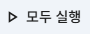


# **01 설치 & import**

In [ ]:
# ============================
# 🔗 GitHub 연동 설정 (Colab 전용)
# ============================
try:
    from google.colab import userdata
    IN_COLAB = True
    print("✅ Google Colab 환경 감지됨")
except:
    IN_COLAB = False
    print("⚠️ 로컬/GitHub Actions 환경")

if IN_COLAB:
    import os

    # Colab Secrets에서 API 키 읽기
    os.environ["GITHUB_TOKEN"] = userdata.get('GITHUB_TOKEN')
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    os.environ["NEWSAPI_KEY"] = userdata.get('NEWSAPI_KEY')
    os.environ["NEWSDATA_API_KEY"] = userdata.get('NEWSDATA_API_KEY')
    os.environ["GNEWS_API_KEY"] = userdata.get('GNEWS_API_KEY')
    os.environ["MEDIASTACK_API_KEY"] = userdata.get('MEDIASTACK_API_KEY')
    os.environ["SERPAPI_KEY"] = userdata.get('SERPAPI_KEY')
    os.environ["CURRENTS_API_KEY"] = userdata.get('CURRENTS_API_KEY')
    os.environ["GMAIL_USER"] = userdata.get('GMAIL_USER')
    os.environ["GMAIL_APP_PASSWORD"] = userdata.get('GMAIL_APP_PASSWORD')
    os.environ["TO_EMAIL"] = userdata.get('TO_EMAIL')
    os.environ["TO_EMAIL_TEST"] = userdata.get('TO_EMAIL_TEST')  # 🔹 새로 추가

    print("✅ Colab Secrets에서 API 키 로드 완료")

✅ Google Colab 환경 감지됨
✅ Colab Secrets에서 API 키 로드 완료


In [ ]:
# ============================
# 1. 라이브러리 설치
# ============================
if IN_COLAB:
    get_ipython().system('pip install -q requests pandas python-dateutil openai beautifulsoup4 feedparser')

import os
import time
import json
import requests
import pandas as pd

from datetime import datetime, timedelta, timezone

import feedparser
from dateutil import parser as dateparser  # 이미 있다면 생략

from openai import OpenAI
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from html import escape as h
# IPython은 Colab에서만 필요
try:
    from IPython.display import HTML, display
except ImportError:
    # GitHub Actions 환경용 더미 함수
    def display(obj):
        pass
    def HTML(text):
        return text
    pass
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from concurrent.futures import ThreadPoolExecutor, as_completed

# **02 설정 (API 키, 날짜, 주제, 키워드, 상수)**

In [ ]:
# ============================================================
# 2. API 키 & 기본 설정
# ============================================================

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
NEWSAPI_KEY = os.environ.get("NEWSAPI_KEY")
NEWSDATA_API_KEY = os.environ.get("NEWSDATA_API_KEY")
GNEWS_API_KEY = os.environ.get("GNEWS_API_KEY")
MEDIASTACK_API_KEY = os.environ.get("MEDIASTACK_API_KEY")
SERPAPI_KEY = os.environ.get("SERPAPI_KEY")
CURRENTS_API_KEY = os.environ.get("CURRENTS_API_KEY")


NEWSDATA_BASE_URL_LATEST = "https://newsdata.io/api/1/latest"



In [ ]:
# 사용할 GPT mini 모델 이름 (예: "gpt-4.1-mini", 나중에 "gpt-5.1-mini"로 교체 가능)
MODEL_NAME = "gpt-4.1-mini"

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
client = OpenAI()

# ============================================================
# GitHub Pages 설정
# ============================================================
# GitHub 계정 아이디와 레포 이름
GITHUB_OWNER = "hancom-inspace"              # 예: "junwoo0920"
GITHUB_REPO  = "Weekly-Newsletter"    # GitHub에서 만든 레포 이름

# GitHub Pages 최종 URL (Settings → Pages에 표시되는 주소)
# 보통 형태: https://{owner}.github.io/{repo}
BASE_URL = f"https://{GITHUB_OWNER}.github.io/{GITHUB_REPO}"

# GitHub Personal Access Token (Colab 셀에서 os.environ["GITHUB_TOKEN"] 로 미리 넣어둔 값)
GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN")


# 헤더 이미지 / 로고 / 기본 썸네일
HEADER_BACKGROUND = "https://static.wixstatic.com/media/b749e1_60701dc82eb542149d95637ce7a34802~mv2_d_5568_3712_s_4_2.jpg/v1/fill/w_1553,h_1071,al_c,q_85,usm_0.66_1.00_0.01,enc_avif,quality_auto/b749e1_60701dc82eb542149d95637ce7a34802~mv2_d_5568_3712_s_4_2.jpg"
LOGO_URL = "https://static.wixstatic.com/media/0c4f16_c8132c52e3ef485286a1f0ec457a5cdb~mv2.png/v1/fill/w_111,h_44,al_c,q_85,usm_0.66_1.00_0.01,enc_avif,quality_auto/logotype_vert_rgb_v2__w__w500.png%201x,%20https://static.wixstatic.com/media/0c4f16_c8132c52e3ef485286a1f0ec457a5cdb~mv2.png/v1/fill/w_222,h_88,al_c,q_85,usm_0.66_1.00_0.01,enc_avif,quality_auto/logotype_vert_rgb_v2__w__w500.png%202x"
DEFAULT_THUMB = "https://e0.pxfuel.com/wallpapers/597/629/desktop-wallpaper-fun-funny-funny-funny-space.jpg"

CONTENT_WIDTH = 700

# ============================
# 2. 날짜 자동 설정 (UTC 기준 7일 전 ~ 오늘)
# ============================
# KST 시간대 정의
KST = timezone(timedelta(hours=9))

# 현재 KST 시간 기준
now_kst = datetime.now(KST)
today_kst = now_kst.date()

# 검색 범위: KST 기준 7일 전 00:00:00 ~ 오늘 23:59:59
seven_days_ago_kst = today_kst - timedelta(days=7)

# KST 날짜를 UTC datetime으로 변환 (API는 UTC 필요)
date_from_utc = datetime.combine(seven_days_ago_kst, datetime.min.time()).replace(tzinfo=KST).astimezone(timezone.utc)
date_to_utc = datetime.combine(today_kst, datetime.max.time()).replace(tzinfo=KST).astimezone(timezone.utc)

DATE_FROM = date_from_utc.strftime("%Y-%m-%d")
DATE_TO = date_to_utc.strftime("%Y-%m-%d")

print("=" * 60)
print(f"🕐 현재 KST 시간: {now_kst.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📅 검색 범위 (KST): {seven_days_ago_kst} ~ {today_kst}")
print(f"📅 검색 범위 (UTC): {DATE_FROM} ~ {DATE_TO}")
print("=" * 60)


# 영어 + 한국어 기사 같이 사용
LANGUAGES = ["en", "ko"]

# ============================
# 2. 주제 정의 & 키워드
# ============================
TOPIC_DESC = {
    1: "GeoINT / 지리공간 정보, 위성·지도 기반 정보 분석",
    2: "항공 / 드론·무인기(UAV/UAS) 동향",
    3: "AI 데이터·분석 플랫폼 / MLOps·자동화",
    4: "위성 영상 / SAR·광학·하이퍼스펙트럴 이미지 분석"
}

TOPIC_ICON = {
    1: "🌐",   # GEOINT
    2: "✈️",   # 항공
    3: "🤖",   # AI 플랫폼
    4: "🛰️",   # 위성영상
}

# 영어 + 한글 키워드 혼합
TOPIC_KEYWORDS = {
    1: [
        # 기존 키워드
        "geospatial intelligence", "GeoINT",
        "geospatial analytics security",
        "geospatial data national security",
        "지리공간 정보",
        "위성 이미지 분석",
        "OSINT 위성",
        "위성 기반 정보전",

        # 🔹 범위를 넓히는 추가 키워드들
        "geospatial analytics",
        "geospatial data",
        "geospatial mapping",
        "location intelligence",
        "mapping platform",
        "map intelligence",

        "geospatial startup",
        "geospatial company",
        "geospatial SaaS",

        # ✅ 한글 키워드 대폭 확장
        "지리공간 정보", "위성 이미지 분석", "OSINT 위성",
        "공간정보", "지리정보시스템", "GIS 플랫폼",
        "위치 기반 서비스", "위성영상 분석", "공간 데이터",
        "지도 서비스", "위치정보 기술", "공간정보 산업",
        "국토정보", "지적정보", "측량 기술",  # 🆕 추가
    ],
    2: [
        "drone industry",
        "UAV UAS technology",
        "urban air mobility",
        "drone regulation",
        "드론 산업",
        "무인기",
        "도심 항공 모빌리티",
        "UAM 규제",
        "드론 방산",

        # 산업별 드론 활용
        "commercial drone",
        "enterprise drone",
        "industrial drone",
        "drone services",
        "drone inspection",
        "drone surveillance",
        "drone monitoring",

        "drone in logistics",
        "drone delivery",
        "warehouse drone",
        "last mile delivery drone",

        "drone in agriculture",
        "agricultural drone",
        "precision agriculture drone",

        "drone energy inspection",
        "power line inspection drone",
        "oil gas drone inspection",

        # ✅ 한글 드론 키워드 확장
        "드론 산업", "무인기", "도심 항공 모빌리티",
        "드론 배송", "물류 드론", "농업 드론",
        "드론 규제", "드론 안전", "드론 기술",
        "UAM 서비스", "에어택시", "하늘길",  # 🆕 추가
        "드론 스타트업", "드론 시장", "드론 정책",  # 🆕 추가

        # 드론 플랫폼 / 소프트웨어
        "drone software platform",
        "drone data platform",
        "UAS management",
        "fleet management drone",
        "drone analytics",

        "BVLOS drone",
        "drone autonomy",
        "autonomous drone",
        "drone AI navigation",

        "drone startup",
        "drone company",
        "UAS startup"
    ],
    3: [
        # 기존 키워드
        "AI data platform",
        "AI analytics platform",
        "MLOps platform",
        "data automation platform",
        "AI 데이터 플랫폼",
        "MLOps",
        "데이터 분석 플랫폼",
        "AI 분석 플랫폼",

        # 새로 추가하는 키워드들 (AI 기사 폭 넓히기)
        "AI infrastructure",
        "AI cloud platform",
        "LLM platform",
        "large language model platform",
        "enterprise AI platform",
        "enterprise AI",
        "gen AI platform",
        "generative AI platform",
        "generative AI for business",
        "RAG platform",
        "retrieval augmented generation",
        "vector database",
        "feature store",
        "model deployment",
        "model serving",
        "LLMOps",

        # 한국어 키워드 (국내 기사 대비)
        "AI 인프라",
        "AI 클라우드 플랫폼",
        "LLM 플랫폼",
        "대규모 언어모델",
        "엔터프라이즈 AI",
        "기업용 AI",
        "생성형 AI 플랫폼",
        "생성형 AI 인프라",
        "RAG 플랫폼",
        "벡터 데이터베이스",
        "모델 배포",
        "모델 서빙",
        "LLM 운영",

         # 좀 더 범용적인 AI 비즈니스/엔터프라이즈 키워드 추가
        "enterprise AI",
        "AI strategy",
        "AI adoption",
        "AI transformation",
        "AI in business",
        "AI for enterprises",
        "AI for industry",
        "AI automation",

        "인공지능 전략",
        "기업 AI 도입",
        "AI 업무 자동화",
        "엔터프라이즈 AI 도입"

        # ✅ 한글 AI 키워드 확장
        "AI 데이터 플랫폼", "MLOps", "인공지능 인프라",
        "기업 AI", "생성형 AI", "AI 도입",
        "AI 클라우드", "LLM 플랫폼", "AI 전략",
        "AI 혁신", "디지털 전환", "AI 자동화",  # 🆕 추가
        "기업용 AI", "산업 AI", "AI 서비스",  # 🆕 추가
    ],

    4: [
        "satellite imagery processing",
        "SAR satellite analytics",
        "optical satellite imagery analysis",
        "hyperspectral satellite data",
        "위성 영상",
        "SAR 위성",
        "광학 위성 영상",
        "하이퍼스펙트럴 영상",
        "위성 이미지 분석",

        # 위성 데이터 산업 / 서비스
        "satellite data platform",
        "satellite data analytics",
        "earth observation data",
        "EO data platform",
        "space data analytics",

        "satellite imagery services",
        "commercial satellite imagery",
        "satellite data services",


        # 산업별 위성 활용
        "satellite data for agriculture",
        "satellite data for insurance",
        "satellite data for climate",
        "satellite data for energy",
        "satellite data for supply chain",

        # ✅ 한글 위성 키워드 확장
        "위성 영상", "SAR 위성", "광학 위성 영상",
        "위성 데이터", "지구관측", "위성정보",
        "위성영상 분석", "원격탐사", "우주 산업",  # 🆕 추가
        "위성 서비스", "위성 기술", "위성 활용",  # 🆕 추가
    ]
}

# 1차 후보 개수 (토픽당 NewsAPI에서 넉넉히 가져오기)
ARTICLES_PER_TOPIC_RAW = 100

# 언어별 목표 개수 (한글 30% : 영어 70%)
ARTICLES_PER_LANG_KO = 30   # 한글: 30%
ARTICLES_PER_LANG_EN = 70   # 영어: 70%

# 최종 뉴스레터에 반드시 보여줄 개수
ARTICLES_PER_TOPIC_FINAL = 3

# [추가] 한 토픽에서 "메인 3 + 추가 최소 6"을 확보하기 위한 전체 최소 개수
MIN_TOTAL_PER_TOPIC = ARTICLES_PER_TOPIC_FINAL + 6  # 3 + 6 = 9


🕐 현재 KST 시간: 2025-12-12 17:31:12
📅 검색 범위 (KST): 2025-12-05 ~ 2025-12-12
📅 검색 범위 (UTC): 2025-12-04 ~ 2025-12-12


# **03 NewsAPI로 기사 수집**

In [ ]:
# ============================
# 3. NewsAPI에서 기사 수집
# ============================
def search_news_newsapi(query, from_date, to_date, language=None, page_size=50):
    """
    NewsAPI (2순위 보조 소스 1)
    """
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": query,
        "from": from_date,
        "to": to_date,
        "sortBy": "publishedAt",
        "pageSize": page_size,
        "apiKey": NEWSAPI_KEY,
    }
    if language:
        params["language"] = language

    r = requests.get(url, params=params, timeout=10)
    r.raise_for_status()
    return r.json().get("articles", [])


def search_news_mediastack(query, from_date, to_date, language=None, page_size=30):
    """
    MediaStack (2순위 보조 소스 2)
    - 무료 플랜이면 HTTPS가 안될 수도 있어서 http로 써야 할 때도 있음. (문서 참고)
    """
    url = "http://api.mediastack.com/v1/news"
    limit = min(page_size, 50)

    params = {
        "access_key": MEDIASTACK_API_KEY,
        "keywords": query,
        "date_from": from_date,
        "date_to": to_date,
        "sort": "published_desc",
        "limit": limit,
    }
    if language:
        # mediastack는 언어 코드가 en, ko 등 (공식 문서 확인)
        params["languages"] = language

    try:
        r = requests.get(url, params=params, timeout=10)
        r.raise_for_status()
    except Exception as e:
        print(f"[WARN] MediaStack error (q={query}, lang={language}): {e}")
        return []

    data = r.json()
    articles = []
    for item in data.get("data", []):
        articles.append({
            "source": {"name": item.get("source")},
            "author": item.get("author"),
            "title": item.get("title"),
            "description": item.get("description"),
            "content": item.get("description"),
            "url": item.get("url"),
            "publishedAt": item.get("published_at"),  # 또는 published_at/created_at 확인 필요
        })
    return articles

def search_news_serpapi(query, from_date, to_date, language=None, page_size=30):
    """
    SerpAPI Google News (3순위 백업 소스)
    """
    url = "https://serpapi.com/search"
    num = min(page_size, 20)

    params = {
        "engine": "google_news",
        "q": query,
        "api_key": SERPAPI_KEY,
        "num": num,
    }
    if language:
        params["hl"] = language  # hl=ko, hl=en 등

    try:
        r = requests.get(url, params=params, timeout=10)
        r.raise_for_status()
    except Exception as e:
        print(f"[WARN] SerpAPI error (q={query}, lang={language}): {e}")
        return []

    data = r.json()
    results = data.get("news_results") or []
    articles = []
    for item in results:
        # published_date는 사람이 읽기 좋은 문자열일 수 있음 ("3 hours ago" 이런 식이면 나중에 필터에서 걸러질 수 있음)
        articles.append({
            "source": {"name": item.get("source")},
            "author": None,
            "title": item.get("title"),
            "description": item.get("snippet"),
            "content": item.get("snippet"),
            "url": item.get("link"),
            "publishedAt": item.get("date") or item.get("published_date"),
        })
    return articles


def search_news_currents(query, from_date, to_date, language=None, page_size=30):
    """
    Currents API (3순위 백업 소스)
    """
    url = "https://api.currentsapi.services/v1/search"
    limit = min(page_size, 50)

    params = {
        "apiKey": CURRENTS_API_KEY,
        "keywords": query,
        "limit": limit,
    }
    if language:
        params["language"] = language

    # 날짜 필터는 플랜에 따라 동작 방식이 달라서, 필요시 문서 보고 맞게 조정
    params["start_date"] = from_date
    params["end_date"] = to_date

    try:
        r = requests.get(url, params=params, timeout=10)
        r.raise_for_status()
    except Exception as e:
        print(f"[WARN] Currents error (q={query}, lang={language}): {e}")
        return []

    data = r.json()
    results = data.get("news") or []
    articles = []
    for item in results:
        articles.append({
            "source": {"name": item.get("author")},
            "author": item.get("author"),
            "title": item.get("title"),
            "description": item.get("description"),
            "content": item.get("description"),
            "url": item.get("url"),
            "publishedAt": item.get("published"),  # ISO8601인지 확인 필요
        })
    return articles


def search_news_gnews(query, from_date, to_date, language=None, page_size=30):
    """
    GNews API (1순위 메인 소스)
    - 공식 문서 보고 파라미터 이름/제한은 필요시 조정
    """
    url = "https://gnews.io/api/v4/search"
    max_size = min(page_size, 50)  # 무료 플랜은 보통 10~50 제한

    params = {
        "q": query,
        "token": GNEWS_API_KEY,
        "max": max_size,
        "from": from_date,
        "to": to_date,
        "sortby": "publishedAt",
    }
    if language:
        # GNews는 언어코드가 en, ko 등을 지원 (문서 확인해서 맞춰야 함)
        params["lang"] = language

    try:
        r = requests.get(url, params=params, timeout=10)
        r.raise_for_status()
    except Exception as e:
        print(f"[WARN] GNews error (q={query}, lang={language}): {e}")
        return []

    data = r.json()
    articles = []
    for item in data.get("articles", []):
        articles.append({
            "source": {"name": item.get("source", {}).get("name")},
            "author": item.get("author"),
            "title": item.get("title"),
            "description": item.get("description"),
            "content": item.get("content"),
            "url": item.get("url"),
            # GNews는 publishedAt이 ISO8601 형식
            "publishedAt": item.get("publishedAt"),
        })
    return articles


def search_news_newsdata(query, from_date, to_date, language=None, page_size=30):
    """
    NewsData.io 'latest' 엔드포인트를 사용하는 버전
    - 무료 플랜에서도 동작
    - latest는 과거 n일이 아니라, 최근 ~48시간 기준이지만,
      우리는 어차피 NewsAPI에서 일주일치 커버하고,
      NewsData는 "추가 소스" 느낌으로만 쓰면 됨.
    """
    url = NEWSDATA_BASE_URL_LATEST

    # free 플랜에서 한 번에 가져올 수 있는 최대 size는 10개
    # (그 이상 넣으면 에러) :contentReference[oaicite:1]{index=1}
    size = min(page_size, 10)

    params = {
        "apikey": NEWSDATA_API_KEY,
        "q": query,
        "size": size,
    }

    if language:
        params["language"] = language  # "en", "ko" 등

    try:
        r = requests.get(url, params=params, timeout=10)
        r.raise_for_status()
    except requests.exceptions.HTTPError as e:
        status = getattr(e.response, "status_code", None)
        print(f"[WARN] NewsData.io HTTP error (status={status}, q={query}, lang={language}): {e}")
        return []
    except Exception as e:
        print(f"[WARN] NewsData.io error (q={query}, lang={language}): {e}")
        return []

    data = r.json()
    results = data.get("results") or []

    articles = []

    for item in results:
        creator = item.get("creator")
        if isinstance(creator, list):
            author = creator[0] if creator else None
        else:
            author = creator

        articles.append({
            # 기존 NewsAPI article 구조에 맞춰 변환
            "source": {"name": item.get("source_id")},
            "author": author,
            "title": item.get("title"),
            "description": item.get("description"),
            "content": item.get("content"),
            "url": item.get("link"),
            "publishedAt": item.get("pubDate"),  # 예: "2025-12-08 10:30:00"
        })

    return articles


def search_news_topheadlines_kr(page_size=50):
    """
    NewsAPI 'top-headlines' 엔드포인트로
    한국(country=kr) 기사만 가져오는 함수
    """
    url = "https://newsapi.org/v2/top-headlines"
    params = {
        "country": "kr",          # 한국
        "pageSize": page_size,    # 한 번에 가져올 기사 수
        "apiKey": NEWSAPI_KEY,
    }

    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json().get("articles", [])


EXCLUDE_KEYWORDS = [
    "tutorial", "how to", "explained", "explainer", "what is", "history of",
    "advertisement", "sponsored", "review", "buy now", "product page"
]

def is_basic_newsworthy(article):
    """
    노골적인 튜토리얼/광고/상품 페이지 등 1차 필터
    """
    title = (article.get("title") or "").lower()
    description = (article.get("description") or "").lower()
    content = (article.get("content") or "").lower()
    text = " ".join([title, description, content])
    for bad in EXCLUDE_KEYWORDS:
        if bad in text:
            return False
    return True


def collect_articles_for_topic(topic_id, keywords):
    collected_ko = []  # 한글 기사 저장
    collected_en = []  # 영어 기사 저장
    seen_urls = set()

    for kw in keywords:
        for lang in LANGUAGES:
            # 언어별 목표 개수 확인
            if lang == "ko":
                if len(collected_ko) >= ARTICLES_PER_LANG_KO:
                    continue
                remaining = ARTICLES_PER_LANG_KO - len(collected_ko)
                target_list = collected_ko
            else:  # "en"
                if len(collected_en) >= ARTICLES_PER_LANG_EN:
                    continue
                remaining = ARTICLES_PER_LANG_EN - len(collected_en)
                target_list = collected_en

            tier_articles = []

            # -----------------------------
            # 1️⃣ 1순위: GNews
            # -----------------------------
            try:
                gnews_list = search_news_gnews(
                    kw,
                    DATE_FROM,
                    DATE_TO,
                    language=lang,
                    page_size=remaining,
                )
                tier_articles.extend(gnews_list or [])
            except Exception as e:
                print(f"[WARN] GNews error (kw={kw}, lang={lang}): {e}")

            # -----------------------------
            # 2️⃣ 2순위: NewsAPI + MediaStack
            #    (GNews에서 부족하면)
            # -----------------------------
            if len(tier_articles) < remaining:
                rem2 = remaining - len(tier_articles)

                # 2-1) NewsAPI
                try:
                    newsapi_list = search_news_newsapi(
                        kw,
                        DATE_FROM,
                        DATE_TO,
                        language=lang,
                        page_size=rem2,
                    )
                    tier_articles.extend(newsapi_list or [])
                except Exception as e:
                    print(f"[WARN] NewsAPI error (kw={kw}, lang={lang}): {e}")

                # 2-2) MediaStack
                if len(tier_articles) < remaining:
                    rem3 = remaining - len(tier_articles)
                    try:
                        mediastack_list = search_news_mediastack(
                            kw,
                            DATE_FROM,
                            DATE_TO,
                            language=lang,
                            page_size=rem3,
                        )
                        tier_articles.extend(mediastack_list or [])
                    except Exception as e:
                        print(f"[WARN] MediaStack error (kw={kw}, lang={lang}): {e}")

            # -----------------------------
            # 3️⃣ 3순위: SerpAPI + Currents + NewsData.io
            #    (그래도 부족할 때)
            # -----------------------------
            if len(tier_articles) < remaining:
                rem4 = remaining - len(tier_articles)

                # SerpAPI
                try:
                    serp_list = search_news_serpapi(
                        kw,
                        DATE_FROM,
                        DATE_TO,
                        language=lang,
                        page_size=min(rem4, 10),
                    )
                    tier_articles.extend(serp_list or [])
                except Exception as e:
                    print(f"[WARN] SerpAPI error (kw={kw}, lang={lang}): {e}")

                # Currents
                if len(tier_articles) < remaining:
                    rem5 = remaining - len(tier_articles)
                    try:
                        curr_list = search_news_currents(
                            kw,
                            DATE_FROM,
                            DATE_TO,
                            language=lang,
                            page_size=min(rem5, 50),
                        )
                        tier_articles.extend(curr_list or [])
                    except Exception as e:
                        print(f"[WARN] Currents error (kw={kw}, lang={lang}): {e}")

                # NewsData.io (기존 함수 재사용)
                if len(tier_articles) < remaining:
                    rem6 = remaining - len(tier_articles)
                    try:
                        newsdata_list = search_news_newsdata(
                            kw,
                            DATE_FROM,
                            DATE_TO,
                            language=lang,
                            page_size=rem6,
                        )
                        tier_articles.extend(newsdata_list or [])
                    except Exception as e:
                        print(f"[WARN] NewsData.io error (kw={kw}, lang={lang}): {e}")

            # 🆕 한글 키워드일 때 top-headlines 추가 수집
            if lang == "ko" and any('\uac00' <= ch <= '\ud7a3' for ch in kw):
                try:
                    extra_kr = search_news_topheadlines_kr(page_size=10)
                    # 키워드 필터링 (관련성 체크)
                    for art in extra_kr:
                        title_text = str(art.get('title', '')).lower()
                        if any(k.lower() in title_text for k in kw.split()):
                            tier_articles.append(art)
                except Exception as e:
                    print(f"[WARN] top-headlines 보강 실패: {e}")


            # -----------------------------
            # 공통 후처리: URL 중복 제거 + 날짜 필터 + 기본 필터
            # -----------------------------
            for a in tier_articles:
                # 언어별 목표 개수 체크
                if lang == "ko" and len(collected_ko) >= ARTICLES_PER_LANG_KO:
                    break
                if lang == "en" and len(collected_en) >= ARTICLES_PER_LANG_EN:
                    break

                url = a.get("url")
                if not url or url in seen_urls:
                    continue

                published_at_raw = a.get("publishedAt")

                # 1) published_at이 아예 없는 경우
                if not published_at_raw:
                    # ✅ 날짜 정보가 없으면 언어 구분 없이 오늘 날짜로 간주
                    published_dt = datetime.fromisoformat(DATE_TO).date()
                    # continue 제거 → 모든 언어 살림
                else:
                    # 2) 날짜 문자열이 이상한 경우를 대비한 try/except
                    try:
                        parsed = dateparser.parse(published_at_raw)
                        if parsed is None:
                            raise ValueError("parsed is None")
                        published_dt = parsed.date()
                    except Exception:
                        # ✅ 파싱 실패 시 언어 구분 없이 오늘 날짜 사용
                        published_dt = datetime.fromisoformat(DATE_TO).date()

                # 3) 날짜 범위 필터 적용 (7일 범위)
                from_dt = datetime.fromisoformat(DATE_FROM).date()
                to_dt = datetime.fromisoformat(DATE_TO).date()
                if not (from_dt <= published_dt <= to_dt):
                    continue

                # 4) 광고/튜토리얼 등 1차 필터
                if not is_basic_newsworthy(a):
                    continue

                # 5) 최종 채택 (언어별 리스트에 추가)
                seen_urls.add(url)
                article_data = {
                    "topic_seed": topic_id,
                    "source_name": a.get("source", {}).get("name"),
                    "author": a.get("author"),
                    "original_title": a.get("title"),
                    "description": a.get("description"),
                    "content": a.get("content"),
                    "url": url,
                    "published_at": str(published_dt),
                }
                target_list.append(article_data)

    # 최종 결과: 한글 + 영어 합치기
    collected = collected_ko + collected_en
    print(f"  └ 주제 {topic_id}: 한글 {len(collected_ko)}개, 영어 {len(collected_en)}개 수집됨")
    return collected




print("=== [1단계] NewsAPI에서 기사 수집 중 ===")

raw_articles = []

for t_id, kws in TOPIC_KEYWORDS.items():
    arts = collect_articles_for_topic(t_id, kws)
    print(f"주제 {t_id} ({TOPIC_DESC[t_id]}) : {len(arts)}개 기사 후보 수집")
    raw_articles.extend(arts)


df_raw = pd.DataFrame(raw_articles)
print("\n[1차 수집 결과 개수] :", len(df_raw))
if IN_COLAB:
    display(df_raw.head())

=== [1단계] NewsAPI에서 기사 수집 중 ===
[WARN] GNews error (q=geospatial intelligence, lang=en): 403 Client Error: Forbidden for url: https://gnews.io/api/v4/search?q=geospatial+intelligence&token=586c0e0ab2389b26fd124f14d26ea50d&max=50&from=2025-12-04&to=2025-12-12&sortby=publishedAt&lang=en
[WARN] MediaStack error (q=geospatial intelligence, lang=en): 429 Client Error: Too Many Requests for url: http://api.mediastack.com/v1/news?access_key=fde7354f83da9954f7735c9a8fdb2d95&keywords=geospatial+intelligence&date_from=2025-12-04&date_to=2025-12-12&sort=published_desc&limit=50&languages=en
[WARN] GNews error (q=geospatial intelligence, lang=ko): 403 Client Error: Forbidden for url: https://gnews.io/api/v4/search?q=geospatial+intelligence&token=586c0e0ab2389b26fd124f14d26ea50d&max=30&from=2025-12-04&to=2025-12-12&sortby=publishedAt&lang=ko
[WARN] MediaStack error (q=geospatial intelligence, lang=ko): 429 Client Error: Too Many Requests for url: http://api.mediastack.com/v1/news?access_key=fde7354f

,topic_seed,source_name,author,original_title,description,content,url,published_at
0,1,"{'name': 'Korea.net', 'icon': 'https://encrypt...",None,"국방부, 남북군사회담 제안···""군사분계선 설정 논의""",None,None,https://www.korea.net/NewsFocus/policies/view?...,2025-12-12
1,1,"{'name': 'Ipsos', 'icon': 'https://encrypted-t...",None,"AI 시대, Ipsos Synthesio GEO로 브랜드 가시성을 높이세요",None,None,https://www.ipsos.com/ko-kr/unlock-your-brand-...,2025-12-12
2,1,"{'name': 'hankyung.com', 'icon': 'https://encr...",None,"스텔라비전, 'GITEX Global 2025'서 글로벌 파트너 3곳과 MOU 체결",None,None,https://www.hankyung.com/article/202510273887O,2025-12-12
3,1,"{'name': '더구루', 'icon': 'https://encrypted-tbn...",None,"한화시스템, 日·덴마크와 연쇄 MOU…우주·해양 방위 글로벌 기술 확보",None,None,https://www.theguru.co.kr/news/article.html?no...,2025-12-12
4,1,"{'name': '브런치', 'icon': 'https://encrypted-tbn...",None,S. Korea proposes inter-Korean,None,None,https://brunch.co.kr/@5e2432a1c7b443a/1162,2025-12-12


# **03-1 언어별 비율 계산 함수**

In [ ]:
# ============================
# 3-1. 언어별 비율 계산 함수 (새로 추가)
# ============================

def calculate_language_ratio(articles):
    """기사 리스트에서 한글/영문 비율 계산"""
    total = len(articles)
    if total == 0:
        return 0, 0, 0, 0

    korean_count = sum(1 for art in articles if is_korean_article(art))
    english_count = total - korean_count

    korean_pct = (korean_count / total) * 100
    english_pct = (english_count / total) * 100

    return korean_count, english_count, korean_pct, english_pct


def is_korean_article(article_dict):
    """기사가 한글인지 판단"""
    text = " ".join([
        str(article_dict.get("original_title") or ""),
        str(article_dict.get("title_ko") or ""),
        str(article_dict.get("summary_ko") or ""),
    ])
    return any('\uac00' <= ch <= '\ud7a3' for ch in text)

# **04 GPT (엄격 필터링/분류/요약)**

In [ ]:
# ============================
# 4. GPT mini로 요약/분류/필터링
# ============================

SYSTEM_PROMPT_STRICT = """
당신은 B2B 테크 뉴스레터 편집자입니다.
아래 조건을 만족하며 기사를 선별하고 한국어로 정리하세요.

[주제 범위]
1) GeoINT / 지리공간 정보 / 위성정보 / 지도데이터 분석
2) 드론 / UAV / UAM 산업 및 기술
3) AI 데이터·분석 플랫폼 / MLOps / 자동화·엔터프라이즈 AI 인프라
   뿐만 아니라, 다음과 같은 내용도 모두 3번으로 포함합니다.
   - 엔터프라이즈/산업 분야의 AI 도입·전략·거버넌스
   - 생성형 AI(GenAI) 및 LLM 활용 사례, AI 기반 업무 자동화
   - AI 클라우드 인프라, GPU/가속기, 모델 허브/마켓플레이스
   - 데이터·분석 제품에 AI 기능이 크게 추가되는 경우
   - 기업용 협업툴·업무툴에서 AI 에이전트/코파일럿이 핵심인 업데이트

   단, 순수 소비자용 서비스(게임 추천, SNS 필터 등)만 다루는 기사는 되도록 제외합니다.

4) 위성 영상(SAR·광학·하이퍼스펙트럴) 분석

[특별 규칙: 한컴 인스페이스 관련 기사]
- 기사 제목·본문·설명에 '한컴', '한컴인스페이스', 'Hancom InSpace', 'InSpace' 등이 포함되면
  -> 반드시 keep = true 로 설정하세요.
- 주제 범위를 약간 벗어나도 괜찮습니다.
- topic_final은 1~4 중 가장 관련성이 높은 번호로 선택하세요.
- reason 필드에 반드시 "[한컴 인스페이스 관련]"을 포함하세요.

[불허 컨텐츠]
- 단순 블로그 글, 제품 광고, 기초 설명, 튜토리얼은 keep=false

[출력 JSON 형식]
{
  "keep": true 또는 false,
  "topic_final": 1~4,
  "title_ko": "...",
  "summary_ko": "...",
  "reason": "..."
}
"""

SYSTEM_PROMPT_LOOSE = SYSTEM_PROMPT_STRICT + """
[추가 완화 규칙]
- keep 여부를 판단할 때, 주제와의 관련성이 약간 애매하더라도 가능한 한 keep=true 쪽으로 판단하세요.
- 특히 정부 정책, 공공기관, 대기업의 AI·위성·드론·데이터 관련 발표·MOU·사업계획 등은 폭넓게 포함합니다.
- '튜토리얼/순수 광고/완전 다른 분야(연예·스포츠 등)'가 아닌 이상, 엔터프라이즈/산업·공공과 조금이라도 접점이 보이면 keep=true로 두세요.
"""


def build_user_prompt(row):
    topic_hint = TOPIC_DESC.get(row["topic_seed"], "")
    text = f"""
[seed topic 정보]
- id: {row['topic_seed']}
- desc: {topic_hint}

[기사 메타]
- source: {row.get('source_name')}
- url: {row.get('url')}
- published_at: {row.get('published_at')}

[제목]
{row.get('original_title')}

[description]
{row.get('description')}

[본문 content]
{row.get('content')}
"""
    return text


# 전역 변수로 토큰 누적
if 'total_tokens_used' not in globals():
    total_tokens_used = {"input": 0, "output": 0}


def gpt_process_article(row, system_prompt=SYSTEM_PROMPT_STRICT, model=MODEL_NAME):
    user_prompt = build_user_prompt(row)
    response = client.responses.create(
        model=model,
        input=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0.3  # 🔥 0에서 0.3으로 변경
    )

        # 토큰 사용량 누적
    if hasattr(response, 'usage'):
        total_tokens_used["input"] += response.usage.input_tokens
        total_tokens_used["output"] += response.usage.output_tokens

    text_out = response.output[0].content[0].text
    return json.loads(text_out)



print("\n=== [4단계] GPT 엄격 필터링 + 한컴 강제 포함 로직 ===")


def is_korean_article_row(row) -> bool:
    """
    df_raw의 한 행이 한국어 기사인지 간단히 판별:
    제목/description/content 중 하나에 한글이 있으면 True
    """
    text = " ".join([
        str(row.get("original_title") or ""),
        str(row.get("description") or ""),
        str(row.get("content") or ""),
    ])
    return any('\uac00' <= ch <= '\ud7a3' for ch in text)


strict_rows = []
hancom_keywords = [
    "한컴", "한컴인스페이스", "hancom", "hancom inspace", "inspace", "인스페이스"
]

# 병렬 처리용 함수 정의
def process_single_article(idx_row):
    """
    단일 기사를 GPT로 처리하는 함수
    """
    idx, row = idx_row
    url = row.get("url")
    if not url:
        return None

    # 1) GPT 처리
    try:
        result = gpt_process_article(row, system_prompt=SYSTEM_PROMPT_STRICT)
    except Exception as e:
        print(f"[ERROR] GPT 처리 실패 (url={url}): {e}")
        return None

    # 2) 한컴 키워드 체크
    title_lower = str(row.get("original_title") or "").lower()
    desc_lower = str(row.get("description") or "").lower()

    is_hancom = any(
        kw.lower() in title_lower or kw.lower() in desc_lower
        for kw in hancom_keywords
    )

    keep = result.get("keep", False)
    if is_hancom:
        keep = True
        result["keep"] = True
        result["reason"] = "[한컴 관련] " + result.get("reason", "")

    # 3) keep=False이면 None 반환
    if not keep:
        return None

    # 4) 결과 반환
    return {
        "topic_seed": row.get("topic_seed"),
        "topic_final": row.get("topic_seed"),               # ← 추가!
        "korean_summary": result.get("summary_ko", ""),
        "english_summary": "",
        "title_ko": result.get("title_ko", ""),
        "summary_ko": result.get("summary_ko", ""),
        "title_en": "",                                      # ← 추가!
        "summary_en": "",                                    # ← 추가!
        "original_title": row.get("original_title"),
        "description": row.get("description"),
        "url": url,
        "published_at": row.get("published_at"),
        "source_name": row.get("source_name"),
        "reason": result.get("reason"),
    }

# 병렬 처리 실행
print(f"\n총 {len(df_raw)}개 기사를 병렬 처리합니다 (동시 처리: 20개)...")
with ThreadPoolExecutor(max_workers=20) as executor:
    # 모든 기사를 병렬로 처리하도록 제출
    futures = {executor.submit(process_single_article, (idx, row)): idx
               for idx, row in df_raw.iterrows()}

    # 완료되는 대로 결과 수집
    completed = 0
    for future in as_completed(futures):
        result = future.result()
        if result:
            strict_rows.append(result)

        completed += 1
        # 진행 상황 출력 (20개마다)
        if completed % 20 == 0:  # ← 여기! for 루프 안에 있어요
            print(f"  진행: {completed}/{len(df_raw)} ({completed*100//len(df_raw)}%) - 선별된 기사: {len(strict_rows)}개")

print(f"\n병렬 처리 완료! 총 {len(strict_rows)}개 기사 선별됨")


df_strict = pd.DataFrame(strict_rows)
print("\n[GTP 필터링 후 strict_rows 개수]:", len(df_strict))
if IN_COLAB:
    display(df_strict.head())

# ---------- URL 기준 중복 정리 ----------
dedup_rows = []

if not df_strict.empty:
    for url, group in df_strict.groupby("url"):
        # topic_final 빈도수 기반 선택
        topic_counts = group["topic_final"].value_counts()
        best_topic = int(topic_counts.index[0])

        # 최신 기사 선택
        best_row = group[group["topic_final"] == best_topic] \
            .sort_values("published_at", ascending=False) \
            .iloc[0]

        dedup_rows.append(best_row.to_dict())

df_final = pd.DataFrame(dedup_rows).reset_index(drop=True)

print("\n[URL 중복 제거 후 df_final 개수]:", len(df_final))
if IN_COLAB:
    display(df_final)



=== [4단계] GPT 엄격 필터링 + 한컴 강제 포함 로직 ===

총 400개 기사를 병렬 처리합니다 (동시 처리: 20개)...
  진행: 20/400 (5%) - 선별된 기사: 9개
  진행: 40/400 (10%) - 선별된 기사: 17개
  진행: 60/400 (15%) - 선별된 기사: 29개
  진행: 80/400 (20%) - 선별된 기사: 46개
  진행: 100/400 (25%) - 선별된 기사: 61개
  진행: 120/400 (30%) - 선별된 기사: 81개
  진행: 140/400 (35%) - 선별된 기사: 90개
  진행: 160/400 (40%) - 선별된 기사: 100개
  진행: 180/400 (45%) - 선별된 기사: 107개
  진행: 200/400 (50%) - 선별된 기사: 121개
  진행: 220/400 (55%) - 선별된 기사: 136개
  진행: 240/400 (60%) - 선별된 기사: 151개
  진행: 260/400 (65%) - 선별된 기사: 165개
  진행: 280/400 (70%) - 선별된 기사: 171개
  진행: 300/400 (75%) - 선별된 기사: 180개
  진행: 320/400 (80%) - 선별된 기사: 196개
  진행: 340/400 (85%) - 선별된 기사: 213개
  진행: 360/400 (90%) - 선별된 기사: 230개
  진행: 380/400 (95%) - 선별된 기사: 249개
  진행: 400/400 (100%) - 선별된 기사: 267개

병렬 처리 완료! 총 267개 기사 선별됨

[GTP 필터링 후 strict_rows 개수]: 267


,topic_seed,topic_final,korean_summary,english_summary,title_ko,summary_ko,title_en,summary_en,original_title,description,url,published_at,source_name,reason
0,1,1,IARPA의 HAYSTAC 프로그램은 AI와 IoT 기술을 활용해 사람들의 움직임을...,,IARPA의 HAYSTAC 프로그램: AI와 IoT를 통한 사람들의 움직임 예측,IARPA의 HAYSTAC 프로그램은 AI와 IoT 기술을 활용해 사람들의 움직임을...,,,IARPA의 HAYSTAC 프로그램: AI와 IoT를 통한 사람들의 움직임 예측,None,https://hackernoon.com/lang/ko/AI%EC%99%80-IoT...,2025-12-12,"{'name': 'Hackernoon', 'icon': 'https://encryp...","GeoINT 및 지리공간 정보 분석과 관련된 AI 기술 적용 사례로, 주제 범위 1..."
1,1,1,이종섭 국방부 장관이 미국 국가지리정보국(NGA)을 방문해 위성영상정보 분야에서의 ...,,"이종섭 국방, '하늘의 CIA' 美 국가지리정보국 방문...""위성영상정보 협력 강화""",이종섭 국방부 장관이 미국 국가지리정보국(NGA)을 방문해 위성영상정보 분야에서의 ...,,,"이종섭 국방, '하늘의 CIA' 美 국가지리정보국 방문...""위성영상정보 협력 강화""",None,https://www.spnews.co.kr/news/articleView.html...,2025-12-12,"{'name': 'SPN 서울평양뉴스', 'icon': 'https://encryp...","GeoINT / 지리공간 정보, 위성영상정보 협력 관련 기사로 주제 범위 1에 부합"
2,1,1,수십억 장의 위성사진을 면밀히 분석하여 수천 킬로미터 떨어진 적의 은신처까지 포착하...,,위성사진 수십억장 면밀 분석… 수천㎞ 밖 적 은신처까지 포착 [디펜스 포커스],수십억 장의 위성사진을 면밀히 분석하여 수천 킬로미터 떨어진 적의 은신처까지 포착하...,,,위성사진 수십억장 면밀 분석… 수천㎞ 밖 적 은신처까지 포착 [디펜스 포커스],None,https://www.segye.com/newsView/20221101513470,2025-12-12,"{'name': '세계일보', 'icon': 'https://encrypted-tb...","GeoINT / 지리공간 정보, 위성·지도 기반 정보 분석 분야에 해당하는 기사로,..."
3,1,1,Ipsos가 제공하는 Synthesio GEO는 AI 기술을 활용해 지리공간 데이터...,,"AI 시대, Ipsos Synthesio GEO로 브랜드 가시성을 높이세요",Ipsos가 제공하는 Synthesio GEO는 AI 기술을 활용해 지리공간 데이터...,,,"AI 시대, Ipsos Synthesio GEO로 브랜드 가시성을 높이세요",None,https://www.ipsos.com/ko-kr/unlock-your-brand-...,2025-12-12,"{'name': 'Ipsos', 'icon': 'https://encrypted-t...","GeoINT / 지리공간 정보, 위성·지도 기반 정보 분석 관련 기사로서, AI와 ..."
4,1,1,다비우(Dabeeo)가 위성 데이터 분석 분야에서 맥사 테크놀로지(Maxar Tec...,,"다비우, 맥사 테크놀로지와 협력해 위성 데이터 분석 시장 확장",다비우(Dabeeo)가 위성 데이터 분석 분야에서 맥사 테크놀로지(Maxar Tec...,,,Dabeeo to Expand the Satellite Data Analysis M...,None,https://www.newswire.co.kr/newsRead.php?no=956337,2025-12-12,"{'name': '뉴스와이어', 'icon': 'https://encrypted-t...",[한컴 인스페이스 관련] 해당 기사는 위성 데이터 분석 및 지리공간 정보 분야에 해...



[URL 중복 제거 후 df_final 개수]: 263


,topic_seed,topic_final,korean_summary,english_summary,title_ko,summary_ko,title_en,summary_en,original_title,description,url,published_at,source_name,reason
0,3,3,이 기사는 AI가 복잡하고 수년에 걸쳐 진행되던 제로 트러스트 보안 구현 및 관리를...,,게임 체인저: AI가 제로 트러스트 보안 목표 구현을 단순화하는 방법,이 기사는 AI가 복잡하고 수년에 걸쳐 진행되던 제로 트러스트 보안 구현 및 관리를...,,,Game changer: How AI simplifies implementation...,This article was originally published May 2025...,http://blogs.vmware.com/security/2025/12/game-...,2025-12-10,Vmware.com,"AI 데이터·분석 플랫폼 및 자동화 분야에 해당하며, 제로 트러스트 보안 구현에 A..."
1,2,2,경기북부 드론산업 발전 협의체가 킨텍스에서 모여 드론 및 미래 모빌리티 산업의 발전...,,"경기북부 드론산업 발전 협의체, 킨텍스에서 미래 모빌리티 청사진 논의",경기북부 드론산업 발전 협의체가 킨텍스에서 모여 드론 및 미래 모빌리티 산업의 발전...,,,"경기북부 드론산업 발전 협의체, 킨텍스에서 미래 모빌리티 청사진 논의",None,http://breaknews.com/1159536,2025-12-12,"{'name': 'breaknews.com', 'icon': 'https://enc...",경기북부 드론산업 발전 협의체의 미래 모빌리티 관련 논의는 드론/UAV 산업 동향에...
2,2,2,대전에서 로봇과 드론 분야의 기업들과 청년 기술인재들이 모이는 행사가 개최되어 산업...,,대전서 로봇·드론 기업과 청년 기술인재 한자리에…,대전에서 로봇과 드론 분야의 기업들과 청년 기술인재들이 모이는 행사가 개최되어 산업...,,,대전서 로봇·드론 기업과 청년 기술인재 한자리에…,None,http://breaknews.com/1164923,2025-12-12,"{'name': 'breaknews.com', 'icon': 'https://enc...",드론·무인기(UAV) 산업 및 기술 관련 행사로 seed topic 2에 부합
3,3,3,아레나 그룹은 AI 기반 콘텐츠 추천 모델을 시험하며 독자들이 사이트 내에서 더 오...,,"아레나 그룹, 제로 클릭 시대를 위한 상업 전략 재구성",아레나 그룹은 AI 기반 콘텐츠 추천 모델을 시험하며 독자들이 사이트 내에서 더 오...,,,How The Arena Group is rewriting its commercia...,The company is testing AI-powered content reco...,http://digiday.com/media/how-the-arena-group-i...,2025-12-11,Digiday,AI 데이터·분석 플랫폼 및 AI 기반 업무 자동화 사례에 부합하여 주제 범위 3에...
4,2,2,중국 항공 분야에서 신형 중량급 드론의 시험 비행이 성공적으로 이루어졌다. 이 드론...,,"중국 항공, 신형 중량급 드론 시험 비행 성공…화물 운송 UAV 가능성 주목",중국 항공 분야에서 신형 중량급 드론의 시험 비행이 성공적으로 이루어졌다. 이 드론...,,,"Chinese aviation tests new heavy-lift drones, ...",None,http://en.people.cn/n3/2025/1212/c90000-204014...,2025-12-12,"{'name': 'People's Daily Online', 'icon': 'htt...","항공/드론·무인기(UAV/UAS) 동향에 부합하는 기사로, 신형 중량급 드론 시험과..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,1,1,네이버가 공간지능 분야에서 경쟁 우위를 확보하기 위해 관련 특허 출원을 최근 5년간...,,'공간지능' 선점 나선 네이버…관련 특허 5년새 5.5배로,네이버가 공간지능 분야에서 경쟁 우위를 확보하기 위해 관련 특허 출원을 최근 5년간...,,,'공간지능' 선점 나선 네이버…관련 특허 5년새 5.5배로,None,https://www.yna.co.kr/view/AKR20241025139900017,2025-12-12,"{'name': '연합뉴스', 'icon': 'https://encrypted-tb...","GeoINT / 지리공간 정보 분야에 해당하며, 공간지능 관련 특허 증가라는 기술 ..."
259,4,4,중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하는 모습을 위성사진을 통해 공개...,,"日, 무인도에 군사시설 빠르게 확충…中매체, 위성사진 공개",중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하는 모습을 위성사진을 통해 공개...,,,"""日, 무인도에 군사시설 빠르게 확충""…中매체, 위성사진 공개",None,https://www.yna.co.kr/view/AKR20251208040300009,2025-12-12,"{'name': '연합뉴스', 'icon': 'https://encrypted-tb...","위성 영상 분석 관련 기사로, SAR·광학 영상 활용 사례에 해당하여 주제 범위 4..."
260,4,4,중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하고 있다는 내용을 위성사진을 통...,,"""일본, 무인도에 군사시설 빠르게 확충""...중국 매체, 위성사진 공개",중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하고 있다는 내용을 위성사진을 통...,,,"""일본, 무인도에 군사시설 빠르게 확충""...중국 매체, 위성사진 공개",None,https://www.ytn.co.kr/_ln/0104_202512081049036936,2025-12-12,"{'name': 'YTN', 'icon': 'https://encrypted-tbn...","위성 영상 분석을 통한 군사시설 확충 동향 보도로, 주제 범위 4번(위성 영상 분석..."
261,3,3,AMD는 PC부터 데이터센터에 이르기까지 AI 이니셔티브를 비즈니스 혁신으로 전환하...,,AMD의 엔드투엔드 하드웨어가 AI 혁신을 실질적 성과로 전환하는 방법,AMD는 PC부터 데이터센터에 이르기까지 AI 이니셔티브를 비즈니스 혁신으로 전환하...,,,How AMD End-to-End Hardware Turns AI Innovatio...,"From PCs to data centers, AMD delivers the com...",https://www.zdnet.com/paid-content/article/how...,2025-12-10,ZDNet,"AI 데이터·분석 플랫폼 및 AI 클라우드 인프라 관련 내용으로, AI 혁신과 엔터..."


# **05 부족한 토픽은 백업 프롬프트로 채우기 + 토픽당 3개 맞추기**

In [ ]:
# ============================
# 5. 주제별 최소 3개 강제: 부족분은 백업 프롬프트로 채우기
#    + 한컴 인스페이스 관련 기사 우선순위 부여
# ============================

def detect_hancom_priority(row):
    """
    한컴 인스페이스 관련 기사이면 priority=1, 아니면 0
    - 제목 / 한글제목 / 한글요약 / 소스명에 '한컴', 'InSpace' 등이 포함되면 우선순위 부여
    """
    text = " ".join([
        str(row.get("original_title", "") or ""),
        str(row.get("title_ko", "") or ""),
        str(row.get("summary_ko", "") or ""),
        str(row.get("source_name", "") or "")
    ]).lower()

    keywords = [
        "한컴인스페이스",
        "한컴 인스페이스",
        "hancominspace",
        "hancom inspace",
        "hancom",
        "inspace",
    ]

    return 1 if any(k in text for k in keywords) else 0


def fill_topic_with_backup(topic_id, needed, df_final, df_raw):
    """
    topic_id에 대해 df_final에 부족한 개수(needed)만큼
    df_raw에서 아직 안 쓴 URL을 골라
    '느슨한' 프롬프트로 요약해서 df_final에 추가.
    """
    used_urls = set(df_final["url"].tolist())
    cand = df_raw[(df_raw["topic_seed"] == topic_id) & (~df_raw["url"].isin(used_urls))]
    cand = cand.sort_values("published_at", ascending=False)

    added_rows = []
    for _, row in cand.iterrows():
        if needed <= 0:
            break
        try:
            result = gpt_process_article(row, system_prompt=SYSTEM_PROMPT_LOOSE)
        except Exception as e:
            print(f"[백업 에러] topic {topic_id}, url={row.get('url')}: {e}")
            continue

        # 어차피 seed topic용이므로 강제로 topic_final/keep 보정
        result_topic = topic_id
        title_ko = result.get("title_ko")
        summary_ko = result.get("summary_ko")
        reason = result.get("reason", "")

        if not title_ko or not summary_ko:
            # 너무 부실하면 스킵
            continue

        added_rows.append({
            "topic_final": result_topic,
            "keep": True,
            "title_ko": title_ko,
            "summary_ko": summary_ko,
            "original_title": row.get("original_title"),
            "url": row.get("url"),
            "published_at": row.get("published_at"),
            "source_name": row.get("source_name"),
            "reason": f"[백업기사] {reason}",
        })
        needed -= 1
        time.sleep(0.05)

    if added_rows:
        df_add = pd.DataFrame(added_rows)
        df_final = pd.concat([df_final, df_add], ignore_index=True)

    return df_final


# 현재 토픽별 개수 확인 후 부족하면 채우기
for t in [1, 2, 3, 4]:
    cur = df_final[df_final["topic_final"] == t]
    cnt = len(cur)

    # [수정] 예전에는 "3개 이상이면 통과"였는데,
    # 이제는 "최소 9개(MIN_TOTAL_PER_TOPIC) 이상"이어야 통과
    if cnt >= MIN_TOTAL_PER_TOPIC:
        continue

    needed = MIN_TOTAL_PER_TOPIC - cnt
    print(
        f"토픽 {t} 보강 필요: {cnt}개 → {MIN_TOTAL_PER_TOPIC}개로, "
        f"{needed}개 백업 수집 시도"
    )
    df_final = fill_topic_with_backup(t, needed, df_final, df_raw)

# 그래도 혹시 부족하면(NewsAPI에 기사 자체가 없는 경우) 경고만 찍고 넘어감
for t in [1, 2, 3, 4]:
    cnt = len(df_final[df_final["topic_final"] == t])
    if cnt < ARTICLES_PER_TOPIC_FINAL:
        print(f"[경고] 토픽 {t}는 NewsAPI에 기사가 부족해서 {cnt}개만 표시됩니다.")

# ---------- 한컴 인스페이스 여부 플래그 ----------
df_final["hancom_priority"] = df_final.apply(detect_hancom_priority, axis=1)
print("한컴 인스페이스 관련 기사 수:", int(df_final["hancom_priority"].sum()))

# 여기서는 정렬하지 않고, 뒤에서 '사회적 관심 기반 priority'를 계산한 다음에 정렬합니다.


print("\n[백업 포함 최종 기사 개수] :", len(df_final))
if IN_COLAB:
    display(df_final)

df_final.to_csv("newsletter_articles.csv", index=False)
print("CSV 저장 완료: newsletter_articles.csv")


한컴 인스페이스 관련 기사 수: 1

[백업 포함 최종 기사 개수] : 263


,topic_seed,topic_final,korean_summary,english_summary,title_ko,summary_ko,title_en,summary_en,original_title,description,url,published_at,source_name,reason,hancom_priority
0,3,3,이 기사는 AI가 복잡하고 수년에 걸쳐 진행되던 제로 트러스트 보안 구현 및 관리를...,,게임 체인저: AI가 제로 트러스트 보안 목표 구현을 단순화하는 방법,이 기사는 AI가 복잡하고 수년에 걸쳐 진행되던 제로 트러스트 보안 구현 및 관리를...,,,Game changer: How AI simplifies implementation...,This article was originally published May 2025...,http://blogs.vmware.com/security/2025/12/game-...,2025-12-10,Vmware.com,"AI 데이터·분석 플랫폼 및 자동화 분야에 해당하며, 제로 트러스트 보안 구현에 A...",0
1,2,2,경기북부 드론산업 발전 협의체가 킨텍스에서 모여 드론 및 미래 모빌리티 산업의 발전...,,"경기북부 드론산업 발전 협의체, 킨텍스에서 미래 모빌리티 청사진 논의",경기북부 드론산업 발전 협의체가 킨텍스에서 모여 드론 및 미래 모빌리티 산업의 발전...,,,"경기북부 드론산업 발전 협의체, 킨텍스에서 미래 모빌리티 청사진 논의",None,http://breaknews.com/1159536,2025-12-12,"{'name': 'breaknews.com', 'icon': 'https://enc...",경기북부 드론산업 발전 협의체의 미래 모빌리티 관련 논의는 드론/UAV 산업 동향에...,0
2,2,2,대전에서 로봇과 드론 분야의 기업들과 청년 기술인재들이 모이는 행사가 개최되어 산업...,,대전서 로봇·드론 기업과 청년 기술인재 한자리에…,대전에서 로봇과 드론 분야의 기업들과 청년 기술인재들이 모이는 행사가 개최되어 산업...,,,대전서 로봇·드론 기업과 청년 기술인재 한자리에…,None,http://breaknews.com/1164923,2025-12-12,"{'name': 'breaknews.com', 'icon': 'https://enc...",드론·무인기(UAV) 산업 및 기술 관련 행사로 seed topic 2에 부합,0
3,3,3,아레나 그룹은 AI 기반 콘텐츠 추천 모델을 시험하며 독자들이 사이트 내에서 더 오...,,"아레나 그룹, 제로 클릭 시대를 위한 상업 전략 재구성",아레나 그룹은 AI 기반 콘텐츠 추천 모델을 시험하며 독자들이 사이트 내에서 더 오...,,,How The Arena Group is rewriting its commercia...,The company is testing AI-powered content reco...,http://digiday.com/media/how-the-arena-group-i...,2025-12-11,Digiday,AI 데이터·분석 플랫폼 및 AI 기반 업무 자동화 사례에 부합하여 주제 범위 3에...,0
4,2,2,중국 항공 분야에서 신형 중량급 드론의 시험 비행이 성공적으로 이루어졌다. 이 드론...,,"중국 항공, 신형 중량급 드론 시험 비행 성공…화물 운송 UAV 가능성 주목",중국 항공 분야에서 신형 중량급 드론의 시험 비행이 성공적으로 이루어졌다. 이 드론...,,,"Chinese aviation tests new heavy-lift drones, ...",None,http://en.people.cn/n3/2025/1212/c90000-204014...,2025-12-12,"{'name': 'People's Daily Online', 'icon': 'htt...","항공/드론·무인기(UAV/UAS) 동향에 부합하는 기사로, 신형 중량급 드론 시험과...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,1,1,네이버가 공간지능 분야에서 경쟁 우위를 확보하기 위해 관련 특허 출원을 최근 5년간...,,'공간지능' 선점 나선 네이버…관련 특허 5년새 5.5배로,네이버가 공간지능 분야에서 경쟁 우위를 확보하기 위해 관련 특허 출원을 최근 5년간...,,,'공간지능' 선점 나선 네이버…관련 특허 5년새 5.5배로,None,https://www.yna.co.kr/view/AKR20241025139900017,2025-12-12,"{'name': '연합뉴스', 'icon': 'https://encrypted-tb...","GeoINT / 지리공간 정보 분야에 해당하며, 공간지능 관련 특허 증가라는 기술 ...",0
259,4,4,중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하는 모습을 위성사진을 통해 공개...,,"日, 무인도에 군사시설 빠르게 확충…中매체, 위성사진 공개",중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하는 모습을 위성사진을 통해 공개...,,,"""日, 무인도에 군사시설 빠르게 확충""…中매체, 위성사진 공개",None,https://www.yna.co.kr/view/AKR20251208040300009,2025-12-12,"{'name': '연합뉴스', 'icon': 'https://encrypted-tb...","위성 영상 분석 관련 기사로, SAR·광학 영상 활용 사례에 해당하여 주제 범위 4...",0
260,4,4,중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하고 있다는 내용을 위성사진을 통...,,"""일본, 무인도에 군사시설 빠르게 확충""...중국 매체, 위성사진 공개",중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하고 있다는 내용을 위성사진을 통...,,,"""일본, 무인도에 군사시설 빠르게 확충""...중국 매체, 위성사진 공개",None,https://www.ytn.co.kr/_ln/0104_202512081049036936,2025-12-12,"{'name': 'YTN', 'icon': 'https://encrypted-tbn...","위성 영상 분석을 통한 군사시설 확충 동향 보도로, 주제 범위 4번(위성 영상 분석...",0
261,3,3,AMD는 PC부터 데이터센터에 이르기까지 AI 이니셔티브를 비즈니스 혁신으로 전환하...,,AMD의 엔드투엔드 하드웨어가 AI 혁신을 실질적 성과로 전환하는 방법,AMD는 PC부터 데이터센터에 이르기까지 AI 이니셔티브를 비즈니스 혁신으로 전환하...,,,How AMD End-to-End Hardware Turns AI Innovatio...,"From PCs to data centers, AMD delivers the com...",https://www.zdnet.com/paid-content/article/how...,2025-12-10,ZDNet,"AI 데이터·분석 플랫폼 및 AI 클라우드 인프라 관련 내용으로, AI 혁신과 엔터...",0


CSV 저장 완료: newsletter_articles.csv


# **06 메인(3개) + 더보기 기사 분리**

In [ ]:

# ============================
# 6. 메인(3개) + 더보기(최대 10개) 기사 분리
# ============================

from collections import defaultdict
import difflib
import re

# ---------- 사회적 관심 기반 중요도(priority) 계산 ----------

# 1) 매체 가중치: 기본값 1.0, 주요 매체는 더 높게
SOURCE_WEIGHTS = {
    "연합뉴스": 2.0,
    "조선비즈": 2.0,
    "한국경제": 2.0,
    "매일경제": 2.0,
    "전자신문": 1.5,
    "서울경제": 1.5,
    # 필요하면 여기 계속 추가
}

def _get_source_weight(source_name):
    name = str(source_name or "").strip()
    return SOURCE_WEIGHTS.get(name, 1.0)  # 기본값 1.0

# 2) 후속/분석 기사 여부 (followup_score)
FOLLOWUP_KEYWORDS = [
    "분석", "전망", "영향", "의미",
    "파급", "해설", "왜", "이유"
]

def _get_followup_score(title_ko, original_title):
    text = f"{title_ko or ''} {original_title or ''}"
    return 1 if any(k in text for k in FOLLOWUP_KEYWORDS) else 0

# 3) 클러스터(비슷한 기사 수) + 확산 속도(velocity) 계산
#    - 전체 df_final 기준으로 계산
import pandas as pd  # 이미 위에 있을 가능성이 크지만, 한 번 더 써도 문제 없음

# published_at을 datetime으로 변환 (속도 계산용)
df_final["published_at_dt"] = pd.to_datetime(df_final["published_at"], errors="coerce")

# 비교에 사용할 텍스트 (제목 + 한글제목 + 요약)
texts = (
    df_final["original_title"].fillna("") + " || " +
    df_final["title_ko"].fillna("") + " || " +
    df_final["summary_ko"].fillna("")
).tolist()

times = df_final["published_at_dt"].tolist()
n = len(df_final)

# i번째 기사와 비슷한 기사 인덱스 모음
similar_indices = [set() for _ in range(n)]

for i in range(n):
    for j in range(i + 1, n):
        a = texts[i].lower().strip()
        b = texts[j].lower().strip()
        if not a or not b:
            continue
        sim = difflib.SequenceMatcher(None, a, b).ratio()
        # 유사도 threshold는 0.75 정도로 설정
        if sim >= 0.75:
            similar_indices[i].add(j)
            similar_indices[j].add(i)

cluster_scores = []
velocity_scores = []

for i in range(n):
    cnt = len(similar_indices[i]) + 1

    # (1) cluster_score: 비슷한 기사 개수에 따라 점수 부여
    if cnt <= 1:
        cluster = 0
    elif cnt <= 3:
        cluster = 1
    elif cnt <= 6:
        cluster = 2
    else:
        cluster = 3
    cluster_scores.append(cluster)

    # (2) velocity_score: 짧은 시간 동안 얼마나 많이 나왔는지
    if cnt <= 1:
        velocity = 0
    else:
        idxs = [i] + list(similar_indices[i])
        ts = [times[k] for k in idxs if pd.notnull(times[k])]
        if len(ts) >= 2:
            span_hours = (max(ts) - min(ts)).total_seconds() / 3600.0
            if span_hours <= 48:
                velocity = 2
            elif span_hours <= 168:
                velocity = 1
            else:
                velocity = 0
        else:
            velocity = 0
    velocity_scores.append(velocity)

# 4) df_final에 컬럼으로 붙이기
df_final["cluster_score"]   = cluster_scores
df_final["velocity_score"]  = velocity_scores
df_final["source_weight"]   = df_final["source_name"].apply(_get_source_weight)
df_final["followup_score"]  = df_final.apply(
    lambda r: _get_followup_score(r.get("title_ko"), r.get("original_title")),
    axis=1
)

# 5) priority 계산
df_final["priority"] = (
    df_final["hancom_priority"] * 100 +
    df_final["cluster_score"] * 10 +
    df_final["velocity_score"] * 5 +
    df_final["source_weight"] * 3 +
    df_final["followup_score"] * 2
)

# ✅ 새로 추가: 언어 균형 보너스
print("\n" + "="*60)
print("🎯 언어 균형 조정 중...")
print("="*60)

TARGET_ENGLISH_RATIO = 70  # 목표 영문 비율
BALANCE_BONUS = 8          # 균형 보너스 점수 (너무 크지 않게)

for topic_num in [1, 2, 3, 4]:
    topic_mask = df_final["topic_final"] == topic_num
    topic_articles = df_final[topic_mask].to_dict('records')

    if len(topic_articles) == 0:
        continue

    ko_count, en_count, ko_pct, en_pct = calculate_language_ratio(topic_articles)

    # 영문이 부족하면 영문 기사에 보너스
    if en_pct < TARGET_ENGLISH_RATIO - 10:  # 60% 미만이면
        english_bonus = BALANCE_BONUS
        korean_bonus = 0
        print(f"[토픽 {topic_num}] 영문 부족({en_pct:.1f}%) → 영문 기사 보너스 +{english_bonus}")

    # 한글이 부족하면 한글 기사에 보너스
    elif ko_pct < (100 - TARGET_ENGLISH_RATIO) - 10:  # 20% 미만이면
        english_bonus = 0
        korean_bonus = BALANCE_BONUS
        print(f"[토픽 {topic_num}] 한글 부족({ko_pct:.1f}%) → 한글 기사 보너스 +{korean_bonus}")

    # 균형이 적당하면 보너스 없음
    else:
        english_bonus = 0
        korean_bonus = 0
        print(f"[토픽 {topic_num}] 현재 비율: 영문 {en_pct:.1f}%, 한글 {ko_pct:.1f}% (보너스 없음)")

    # 보너스 적용
    if english_bonus > 0 or korean_bonus > 0:
        topic_indices = df_final[topic_mask].index

        for idx in topic_indices:
            row = df_final.loc[idx]
            text = " ".join([
                str(row.get("original_title") or ""),
                str(row.get("title_ko") or ""),
                str(row.get("summary_ko") or ""),
            ])
            is_korean = any('\uac00' <= ch <= '\ud7a3' for ch in text)

            bonus = korean_bonus if is_korean else english_bonus
            df_final.at[idx, "priority"] += bonus

# 보너스 적용 후 재정렬
df_final = df_final.sort_values(
    ["priority", "published_at_dt"],
    ascending=[False, False]
).reset_index(drop=True)

print("\n✅ 언어 균형 조정 완료\n")

print("\n[중요도(priority) 계산 후 상위 5개]:")
if IN_COLAB:
    display(df_final.head())


topic_main_articles = {}
topic_extra_articles = {}

def _normalize_text(s):
    if s is None:
        return ""
    s = s.lower()
    # 한글(가-힣), 영문, 숫자만 남기고 나머지는 공백 처리
    s = re.sub(r"[^0-9a-zA-Z\uAC00-\uD7A3]+", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

def is_near_duplicate(text_a, text_b, threshold=0.8):
    """
    두 텍스트가 거의 같은지 판단.
    threshold는 0.8~0.9 사이에서 조절하면 됨.
    """
    a = _normalize_text(text_a)
    b = _normalize_text(text_b)
    if not a or not b:
        return False
    return difflib.SequenceMatcher(None, a, b).ratio() >= threshold

def df_row_to_article(row, topic_num):
    topic_title = f"{topic_num}) {TOPIC_DESC[topic_num]}"
    return {
        "topic_title": topic_title,
        "ko_title": row["title_ko"],
        "orig_title": row["original_title"],
        "topic_num": str(topic_num),
        "url": row["url"],
        "date": row["published_at"],
        "summary": row["summary_ko"],
        "priority": row.get("priority", 0),
    }

for topic_num in [1, 2, 3, 4]:
    topic_df = df_final[df_final["topic_final"] == topic_num].copy()

    # 1) priority 순으로만 정렬 (날짜 정렬 제거)
    topic_df = topic_df.sort_values(
        "priority",
        ascending=False
    )


    # 2) 거의 동일한 내용(제목/요약) 기사 제거
    #    - 제목(한글/원문)이 완전히 같거나
    #    - 제목 텍스트 유사도가 threshold 이상이면 중복으로 간주
    dedup_rows = []
    for _, row in topic_df.iterrows():
        # 한글 제목이 있으면 우선 사용하고, 없으면 원 제목 사용
        cur_title_raw = row.get("title_ko") or row.get("original_title") or ""
        cur_title = _normalize_text(cur_title_raw)
        # 요약은 매체마다 표현이 크게 달라서, 중복 판정은 "제목" 위주로만 진행
        cur_text = cur_title

        is_dup = False
        for kept in dedup_rows:
            kept_title_raw = kept.get("title_ko") or kept.get("original_title") or ""
            kept_title = _normalize_text(kept_title_raw)
            kept_text = kept_title

            # ① 제목이 완전히 같거나
            # ② 제목 텍스트 유사도가 threshold 이상이면 중복 기사로 처리
            if cur_title and kept_title and cur_title == kept_title:
                is_dup = True
                break
            if is_near_duplicate(cur_text, kept_text, threshold=0.75):
                is_dup = True
                break

        if not is_dup:
            dedup_rows.append(row)

    topic_df = pd.DataFrame(dedup_rows)


    if len(topic_df) == 0:
        print(f"[경고] 토픽 {topic_num}에 기사가 없습니다.")
        topic_main_articles[topic_num] = []
        topic_extra_articles[topic_num] = []
        continue

    # 3) 메인 3개
    main_df = topic_df.head(ARTICLES_PER_TOPIC_FINAL)

    # 4) 추가 기사
    extra_df = topic_df.iloc[ARTICLES_PER_TOPIC_FINAL :]

    main_list = [df_row_to_article(row, topic_num) for _, row in main_df.iterrows()]
    extra_list = [df_row_to_article(row, topic_num) for _, row in extra_df.iterrows()]

    topic_main_articles[topic_num] = main_list
    topic_extra_articles[topic_num] = extra_list

# 디버그 출력
total_main = sum(len(v) for v in topic_main_articles.values())
total_extra = sum(len(v) for v in topic_extra_articles.values())
print("메인 기사 총 개수:", total_main)
print("추가 기사 총 개수:", total_extra)
for t in [1, 2, 3, 4]:
    print(f"토픽 {t}: 메인 {len(topic_main_articles[t])}개, 추가 {len(topic_extra_articles[t])}개")

# ✅ 최종 언어 비율 모니터링
print("\n" + "="*60)
print("📊 토픽별 최종 기사 언어 비율")
print("="*60)

for topic_num in [1, 2, 3, 4]:
    main_list = topic_main_articles.get(topic_num, [])
    extra_list = topic_extra_articles.get(topic_num, [])

    all_articles = main_list + extra_list
    ko_count, en_count, ko_pct, en_pct = calculate_language_ratio(all_articles)

    print(f"\n토픽 {topic_num} ({TOPIC_DESC[topic_num]}):")
    print(f"  영문: {en_count}개 ({en_pct:.1f}%)")
    print(f"  한글: {ko_count}개 ({ko_pct:.1f}%)")
    print(f"  총: {len(all_articles)}개")

    # 경고 표시
    if en_pct < 50:
        print(f"  ⚠️ 영문 기사 부족 ({en_pct:.1f}%)")
    elif ko_pct < 20:
        print(f"  ⚠️ 한글 기사 부족 ({ko_pct:.1f}%)")
    else:
        print(f"  ✅ 균형 양호")

print("\n" + "="*60 + "\n")


🎯 언어 균형 조정 중...
[토픽 1] 영문 부족(0.0%) → 영문 기사 보너스 +8
[토픽 2] 영문 부족(0.0%) → 영문 기사 보너스 +8
[토픽 3] 영문 부족(0.0%) → 영문 기사 보너스 +8
[토픽 4] 영문 부족(0.0%) → 영문 기사 보너스 +8

✅ 언어 균형 조정 완료


[중요도(priority) 계산 후 상위 5개]:


,topic_seed,topic_final,korean_summary,english_summary,title_ko,summary_ko,title_en,summary_en,original_title,description,...,published_at,source_name,reason,hancom_priority,published_at_dt,cluster_score,velocity_score,source_weight,followup_score,priority
0,4,4,"한컴인스페이스는 위성영상 분석 기술을 바탕으로 멀티 인텔리전스 체계를 구축하며, 미...",,"[전자신문 1만호 특집] 한컴인스페이스, 위성영상에서 멀티 인텔리전스로…'한국형 팔...","한컴인스페이스는 위성영상 분석 기술을 바탕으로 멀티 인텔리전스 체계를 구축하며, 미...",,,"[전자신문 1만호 특집] 한컴인스페이스, 위성영상에서 멀티 인텔리전스로…'한국형 팔...",None,...,2025-12-12,"{'name': '전자신문', 'icon': 'https://encrypted-tb...",[한컴 관련] [한컴 인스페이스 관련],1,2025-12-12,0,0,1.0,0,103.0
1,4,4,중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하는 모습을 위성사진을 통해 공개...,,"日, 무인도에 군사시설 빠르게 확충…中매체, 위성사진 공개",중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하는 모습을 위성사진을 통해 공개...,,,"""日, 무인도에 군사시설 빠르게 확충""…中매체, 위성사진 공개",None,...,2025-12-12,"{'name': '연합뉴스', 'icon': 'https://encrypted-tb...","위성 영상 분석 관련 기사로, SAR·광학 영상 활용 사례에 해당하여 주제 범위 4...",0,2025-12-12,2,2,1.0,0,33.0
2,4,4,중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하는 모습을 위성사진을 통해 공개...,,"“日, 무인도에 군사시설 빠르게 확충”…中매체, 위성사진 공개 비판",중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하는 모습을 위성사진을 통해 공개...,,,"“日, 무인도에 군사시설 빠르게 확충”…中매체, 위성사진 공개 비판",None,...,2025-12-12,"{'name': '헤럴드경제', 'icon': 'https://encrypted-t...","위성 영상 분석을 통한 군사시설 확충 감시 사례로, 4번 주제인 위성 영상(SAR·...",0,2025-12-12,1,2,1.0,0,23.0
3,4,4,중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하는 모습을 위성사진을 통해 공개...,,"日, 무인도에 군사시설 빠르게 확충‥中매체, 위성사진 공개",중국 매체가 일본이 무인도에 군사시설을 빠르게 확충하는 모습을 위성사진을 통해 공개...,,,"""日, 무인도에 군사시설 빠르게 확충""‥中매체, 위성사진 공개",None,...,2025-12-12,"{'name': 'MBC 뉴스', 'icon': 'https://encrypted-...","위성 영상 분석과 관련된 기사로, SAR·광학 위성 이미지 분석 주제에 부합하여 k...",0,2025-12-12,1,2,1.0,0,23.0
4,1,1,도널드 트럼프 전 대통령이 국가지리공간정보국(NGA)의 새로운 국장으로 미셸 브레덴...,,"트럼프, 국가지리공간정보국(NGA) 수장에 미셸 브레덴캠프 중장 임명",도널드 트럼프 전 대통령이 국가지리공간정보국(NGA)의 새로운 국장으로 미셸 브레덴...,,,Trump Taps Lt. Gen. Michele Bredenkamp To Lead...,None,...,2025-12-12,"{'name': 'SOFREP', 'icon': 'https://encrypted-...","GeoINT / 지리공간 정보 분야의 주요 인사 임명 관련 기사로, 주제 범위 1에...",0,2025-12-12,1,2,1.0,0,23.0


메인 기사 총 개수: 12
추가 기사 총 개수: 243
토픽 1: 메인 3개, 추가 56개
토픽 2: 메인 3개, 추가 54개
토픽 3: 메인 3개, 추가 59개
토픽 4: 메인 3개, 추가 74개

📊 토픽별 최종 기사 언어 비율

토픽 1 (GeoINT / 지리공간 정보, 위성·지도 기반 정보 분석):
  영문: 59개 (100.0%)
  한글: 0개 (0.0%)
  총: 59개
  ⚠️ 한글 기사 부족 (0.0%)

토픽 2 (항공 / 드론·무인기(UAV/UAS) 동향):
  영문: 57개 (100.0%)
  한글: 0개 (0.0%)
  총: 57개
  ⚠️ 한글 기사 부족 (0.0%)

토픽 3 (AI 데이터·분석 플랫폼 / MLOps·자동화):
  영문: 62개 (100.0%)
  한글: 0개 (0.0%)
  총: 62개
  ⚠️ 한글 기사 부족 (0.0%)

토픽 4 (위성 영상 / SAR·광학·하이퍼스펙트럴 이미지 분석):
  영문: 77개 (100.0%)
  한글: 0개 (0.0%)
  총: 77개
  ⚠️ 한글 기사 부족 (0.0%)




# **07 최신 연구동향 (학술지 섹션) 설정**

In [ ]:
# ============================================
# 7. 최신 연구동향 (학술지 섹션) 설정
# ============================================

RESEARCH_SECTION_TITLE = "💡 최신 연구동향"

# 저널별 최대 가져올 논문 수 (저널 2개 × 250편 = 최대 500편)
RESEARCH_MAX_PER_JOURNAL = 50

# 연구동향 전용 고정 썸네일
RESEARCH_THUMB = "https://img.freepik.com/premium-vector/laboratory-research-flat-style-design-vector-illustration-stock-illustration_357500-507.jpg"

# CrossRef에서 사용할 저널 목록 (ISSN 기반)
CROSSREF_JOURNALS = [
    {
        "journal_name": "Remote Sensing (MDPI)",
        "issn": "2072-4292",
        "logo_url": "https://www.mdpi.com/img/journals/rs-logo.png",
        "rss_url": "https://www.mdpi.com/rss/journal/remotesensing",
    },
    {
        "journal_name": "Journal of Applied Remote Sensing (SPIE)",
        "issn": "1931-3195",
        "logo_url": "https://www.spiedigitallibrary.org/by-type/journals/journal-of-applied-remote-sensing/~/media/Images/Journals/JARS/JARS_Cover.ashx",
        # SPIE RSS는 확실한 공식 링크가 없어서 일단 비워두고 CrossRef에 맡김
        "rss_url": None,
    },
]

# ============================================
# OpenAlex 기반 학술 논문 수집 (1순위)
# ============================================

def _openalex_rebuild_abstract(inv_idx: dict) -> str:
    """
    OpenAlex의 abstract_inverted_index를 평문 문자열로 복원하는 유틸 함수.
    inv_idx 예시:
      {
        "remote": [0, 10],
        "sensing": [1],
        ...
      }
    → 위치 인덱스를 기준으로 단어 배열을 만들어 합친다.
    """
    if not inv_idx:
        return ""
    # pos → token 매핑
    pos_map = {}
    for token, positions in inv_idx.items():
        for p in positions:
            pos_map[p] = token
    if not pos_map:
        return ""
    max_pos = max(pos_map.keys())
    tokens = []
    for i in range(max_pos + 1):
        tokens.append(pos_map.get(i, ""))
    return " ".join(t for t in tokens if t).strip()


def collect_research_articles_from_openalex(
    max_per_journal: int = RESEARCH_MAX_PER_JOURNAL,
):
    """
    OpenAlex API를 사용하여 저널별 최신 논문 메타데이터를 수집한다.
    - MDPI, SPIE 둘 다 OpenAlex를 1순위로 사용
    - 반환 형식은 collect_research_articles_from_crossref와 동일하게 맞춘다.
    """
    base_url = "https://api.openalex.org/works"
    headers = {
        "User-Agent": "InspaceNewsletterBot/1.0 (mailto:newsletter@example.com)"
    }

    collected = []

    for j in CROSSREF_JOURNALS:
        journal_name = j["journal_name"]
        issn = j["issn"]
        logo_url = j.get("logo_url", RESEARCH_THUMB)

        # OpenAlex filter:
        #  - primary_location.source.issn : 저널 ISSN
        #  - from_publication_date / to_publication_date : 이번 주 날짜 범위
        oa_filter = ",".join([
            f"primary_location.source.issn:{issn}",
            f"from_publication_date:{DATE_FROM}",
            f"to_publication_date:{DATE_TO}",
        ])

        params = {
            "filter": oa_filter,
            "sort": "publication_date:desc",
            "per_page": max_per_journal,
        }

        print(f"[연구동향-OpenAlex] {journal_name} 논문 목록 수집 (ISSN={issn})")

        try:
            resp = requests.get(base_url, params=params, headers=headers, timeout=10)
            resp.raise_for_status()
            data = resp.json()
        except Exception as e:
            print(f"[연구동향-OpenAlex] {journal_name} 요청 실패: {e}")
            continue

        items = data.get("results") or []
        print(f"[연구동향-OpenAlex] {journal_name} 응답 논문 수:", len(items))

        used = 0
        for it in items[:max_per_journal]:
            # 1) 제목
            original_title = (it.get("title") or it.get("display_name") or "").strip()
            if not original_title:
                continue

            # 2) 초록 (abstract_inverted_index 우선 사용)
            inv = it.get("abstract_inverted_index") or {}
            if inv:
                abstract_clean = _openalex_rebuild_abstract(inv)
            else:
                # 그래도 없으면 OpenAlex가 제공하는 간단 description 또는 빈 문자열
                abstract_clean = (it.get("abstract") or "").strip()

            # 3) 링크 (landing_page_url → pdf_url → doi_url 순서)
            primary_loc = it.get("primary_location") or {}
            landing_url = primary_loc.get("landing_page_url")
            pdf_url = primary_loc.get("pdf_url")

            doi = it.get("doi")  # 보통 'https://doi.org/...' 형태일 수도 있음
            if doi and not doi.startswith("http"):
                doi_url = f"https://doi.org/{doi}"
            else:
                doi_url = doi

            click_url = landing_url or pdf_url or doi_url
            if not click_url:
                # 마지막으로 OpenAlex 자체 링크라도 사용
                click_url = it.get("id")

            # 4) 발행일
            published_at = (it.get("publication_date") or "")[:10]
            if not published_at:
                # 그래도 없으면 이번 주 끝 날짜로 대체
                published_at = DATE_TO

            collected.append({
                "journal_name": journal_name,
                "logo_url": logo_url,
                "original_title": original_title,
                "summary_en": abstract_clean,
                "url": click_url,          # ✅ 뉴스레터에서 클릭되는 링크
                "published_at": published_at,
                # CrossRef와 포맷 맞추기 위해 보너스 필드
                "doi_url": doi_url or click_url,
                "publisher_url": landing_url or pdf_url or doi_url,
            })
            used += 1

        print(f"[연구동향-OpenAlex] {journal_name}: 실제 수집 {used}편")

    # 날짜 기준 내림차순 정렬 (CrossRef 함수와 동일한 정렬 방식 유지)
    def _parse_date_safe(s):
        try:
            return datetime.strptime(s, "%Y-%m-%d")
        except Exception:
            return datetime.now()

    collected = sorted(
        collected,
        key=lambda x: _parse_date_safe(x["published_at"]),
        reverse=True,
    )

    return collected


def collect_research_articles_from_rss(max_per_journal=RESEARCH_MAX_PER_JOURNAL):
    """
    CrossRef가 터졌을 때를 위한 백업 소스:
    MDPI / SPIE RSS에서 논문 메타데이터를 수집해서
    7-2 단계에서 사용하는 것과 동일한 형태의 리스트를 반환한다.
    """
    all_articles = []

    for j in CROSSREF_JOURNALS:
        rss_url = j.get("rss_url")
        if not rss_url:
            # 이 저널은 RSS 주소를 아직 안 넣었으면 스킵
            continue

        print(f"[연구동향-RSS] {j['journal_name']} RSS 수집 시도: {rss_url}")
        try:
            feed = feedparser.parse(rss_url)
        except Exception as e:
            print(f"[연구동향-RSS] {j['journal_name']} RSS 파싱 실패: {e}")
            continue

        if not feed.entries:
            print(f"[연구동향-RSS] {j['journal_name']} RSS 엔트리 없음")
            continue

        # 최신 순으로 되어 있다고 가정하고 앞에서 max_per_journal개만 사용
        for entry in feed.entries[:max_per_journal]:
            title = getattr(entry, "title", "").strip()
            link = getattr(entry, "link", "").strip()

            # pubDate → YYYY-MM-DD 로 변환 시도
            pub_date_str = ""
            if hasattr(entry, "published"):
                try:
                    dt = dateparser.parse(entry.published)
                    if dt:
                        pub_date_str = dt.date().isoformat()
                except Exception:
                    pass

            # 요약 (summary / description)
            summary = getattr(entry, "summary", "") or getattr(entry, "description", "") or ""
            summary = " ".join(str(summary).split())

            # 7-2 단계에서 사용하는 필드 이름에 맞춰서 리턴
            all_articles.append({
                "journal_name": j["journal_name"],
                "logo_url": j["logo_url"],
                "original_title": title,
                "summary_en": summary,
                "url": link,                # ✅ 여기서 바로 저널 원문 링크
                "published_at": pub_date_str or DATE_TO,  # 날짜 못 파싱하면 일단 이번 주 끝 날짜로
            })

        print(f"[연구동향-RSS] {j['journal_name']} RSS에서 {min(len(feed.entries), max_per_journal)}편 수집")

    return all_articles


SYSTEM_PROMPT_RESEARCH = """
당신은 원격탐사(Remote Sensing) / 위성 영상 분석 분야의 연구동향을 정리하는 에디터입니다.

입력으로 학술 논문의 메타데이터(저널명, 영문 제목, 영문 초록/요약, 발행일, 링크)가 주어집니다.
이 정보를 기반으로, 아래 형식의 JSON만 반환하세요.

요구사항:
- 논문 내용을 한국어로 3~4문장 정도로 요약하세요.
- 한국어 제목은 사내 뉴스레터용으로, 너무 길지 않게 30자 내외로 작성하세요.
- 가능한 한, 비전문가도 이해할 수 있도록 부드러운 한국어를 사용하세요.

출력 JSON 형식:
{
  "title_ko": "한국어 제목",
  "summary_ko": "한국어 요약 (3~4문장)"
}
"""

def summarize_research_article_to_ko(meta: dict, model: str = MODEL_NAME):
    global total_tokens_used

    """
    CrossRef에서 가져온 논문 메타 정보를 한국어 제목/요약으로 변환
    meta 예시:
      {
        "journal_name": "...",
        "original_title": "...",
        "summary_en": "...",
        "published_at": "YYYY-MM-DD",
        "url": "...",
      }
    """
    user_prompt = f"""
[저널명]
{meta.get('journal_name')}

[논문 제목]
{meta.get('original_title')}

[논문 요약(영문)]
{meta.get('summary_en')}

[발행일]
{meta.get('published_at')}

[링크]
{meta.get('url')}
"""

    resp = client.responses.create(
        model=model,
        input=[
            {"role": "system", "content": SYSTEM_PROMPT_RESEARCH},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0.3,
    )

    # 토큰 사용량 누적
    if hasattr(resp, 'usage'):
        total_tokens_used["input"] += resp.usage.input_tokens
        total_tokens_used["output"] += resp.usage.output_tokens

    text_out = resp.output[0].content[0].text
    try:
        data = json.loads(text_out)
    except Exception:
        # JSON 파싱 실패 시 간단히 fallback
        data = {
            "title_ko": (meta.get("original_title") or "")[:30],
            "summary_ko": (meta.get("summary_en") or "")[:400],
        }
    return data

def collect_research_articles_from_crossref(
    max_per_journal: int = RESEARCH_MAX_PER_JOURNAL
):
    """
    CrossRef API를 사용하여 저널별 최신 논문 메타데이터를 수집한다.
    반환: 리스트[dict]
      dict = {
        "journal_name": str,
        "logo_url": str,
        "original_title": str,
        "summary_en": str,
        "url": str,
        "published_at": "YYYY-MM-DD",
      }
    """
    collected = []

    headers = {
        "User-Agent": "InspaceNewsletterBot/1.0 (mailto:newsletter@example.com)"
    }
    base_url = "https://api.crossref.org/journals"

    for j in CROSSREF_JOURNALS:
        journal_name = j["journal_name"]
        issn = j["issn"]
        logo_url = j.get("logo_url", RESEARCH_THUMB)

        api_url = f"{base_url}/{issn}/works?sort=published&order=desc&rows={max_per_journal}"
        print(f"[연구동향] {journal_name} 논문 목록 수집 (CrossRef, ISSN={issn})")

        try:
            resp = requests.get(api_url, headers=headers, timeout=15)
            resp.raise_for_status()
        except Exception as e:
            print(f"[연구동향] {journal_name} CrossRef 요청 실패: {e}")
            continue

        try:
            data = resp.json()
        except Exception as e:
            print(f"[연구동향] {journal_name} CrossRef JSON 파싱 실패: {e}")
            continue

        items = (data.get("message") or {}).get("items") or []
        print(f"[연구동향] {journal_name} CrossRef 응답 논문 수:", len(items))

        used = 0
        for it in items[:max_per_journal]:
            title_list = it.get("title") or []
            original_title = title_list[0] if title_list else ""
            if not original_title:
                continue

            abstract_raw = it.get("abstract") or ""
            if abstract_raw:
                try:
                    abstract_clean = BeautifulSoup(abstract_raw, "html.parser").get_text(" ", strip=True)
                except Exception:
                    abstract_clean = abstract_raw
            else:
                abstract_clean = ""

            # --- (1) DOI URL (클릭용) ---
            doi = it.get("DOI")
            doi_url = f"https://doi.org/{doi}" if doi else (it.get("URL") or "")

            # --- (2) publisher URL (크롤링용, 있으면 사용) ---
            publisher_url = None
            for link in it.get("link") or []:
                u = link.get("URL")
                if not u:
                    continue
                # 우선순위: 실제 저널 도메인
                if "spiedigitallibrary.org" in u or "mdpi.com" in u:
                    publisher_url = u
                    break
                if not publisher_url:
                    publisher_url = u

            # --- (3) 발행일 ---
            pub = it.get("published-print") or it.get("published-online") or {}
            date_parts = (pub.get("date-parts") or [[]])[0]
            if date_parts:
                year = date_parts[0]
                month = date_parts[1] if len(date_parts) > 1 else 1
                day = date_parts[2] if len(date_parts) > 2 else 1
                published_at = f"{year:04d}-{month:02d}-{day:02d}"
            else:
                published_at = datetime.now(timezone.utc).date().isoformat()

            collected.append({
                "journal_name": journal_name,
                "logo_url": logo_url,
                "original_title": original_title,
                "summary_en": abstract_clean,

                # ✅ 뉴스레터에서 사용자가 클릭할 링크는 DOI 주소(또는 CrossRef URL)로
                "url": doi_url,

                "published_at": published_at,

                # ✅ 나중에 fallback 크롤링할 때 쓰려고 따로 보관
                "doi_url": doi_url,
                "publisher_url": publisher_url,
            })
            used += 1

        print(f"[연구동향] {journal_name}: 실제 수집 {used}편")

    def _parse_date_safe(s):
        try:
            return datetime.strptime(s, "%Y-%m-%d")
        except Exception:
            return datetime.now()

    collected = sorted(
        collected,
        key=lambda x: _parse_date_safe(x["published_at"]),
        reverse=True,
    )
    return collected


# **07-1 썸네일 추출 (기본 썸네일 포함)**

In [ ]:
# ============================
# 7-1. 썸네일 추출 (후보 영역 한정 + 스마트 필터 + canonical 추적)
# ============================
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlsplit  # urlsplit 추가

# 광고/트래킹 전용 "영구 블랙리스트" (이건 썸네일이 될 일이 없음)
ALWAYS_BAD_HOST_SNIPPETS = [
    "doubleclick.net",
    "googlesyndication.com",
    "scorecardresearch.com",
    "pixel.wp.com",
    "adservice",
    "adsystem",
    "biztoc.com",  # ✨ 애그리게이터 썸네일은 항상 기본 이미지로 대체
]

# 실행 중에 자동으로 쌓이는 "문제 호스트" 카운트
HOST_FAIL_COUNTS = {}        # host -> fail count
HOST_FAIL_THRESHOLD = 3      # 이 횟수 이상 실패하면 그 호스트는 문제 호스트로 간주

# "사이드바/추천 영역"으로 간주할 만한 키워드
SIDEBAR_KEYWORDS = [
    "sidebar", "aside", "related", "recommend", "recom", "widget",
    "trending", "popular", "most-read", "mostread", "sponsor",
    "sponsored", "ads", "advert", "outbrain", "taboola",
]

# "본문 영역"으로 인식할 만한 키워드
MAIN_CONTENT_KEYWORDS = [
    "article", "post", "content", "entry", "story", "main", "body",
]


def _get_host(url: str) -> str:
    try:
        host = urlsplit(url).hostname or ""
        return host.lower()
    except Exception:
        return ""


def _mark_host_fail(host: str):
    if not host:
        return
    HOST_FAIL_COUNTS[host] = HOST_FAIL_COUNTS.get(host, 0) + 1


def is_bad_image_url(url, timeout=3):
    """
    '이건 썸네일로 쓰기엔 수상하다' 싶은 이미지만 골라서 거른다.
    - 광고/트래킹 도메인: 무조건 제외
    - 같은 호스트에서 여러 번 실패하면: 자동으로 "문제 호스트"로 간주
    - 그 외에는 HEAD 기준으로 너무 작은 이미지 / 이미지 아님 / 에러 등만 제외
    """
    if not url:
        return True

    url = url.strip()
    lower = url.lower()
    host = _get_host(url)

    # data: URI, 1x1 pixel 등은 제외
    if lower.startswith("data:"):
        return True

    if "1x1" in lower and (".gif" in lower or ".png" in lower or ".jpg" in lower):
        return True

    # 1) 광고/트래킹 도메인은 영구적으로 제외
    if any(sn in host for sn in ALWAYS_BAD_HOST_SNIPPETS):
        return True

    # 2) 이미 여러 번 실패한 "문제 호스트"는 빠르게 제외
    if HOST_FAIL_COUNTS.get(host, 0) >= HOST_FAIL_THRESHOLD:
        return True

    # 3) 경로 기준으로 이미지 파일처럼 보이는지 판단
    path = urlsplit(url).path.lower()
    looks_like_image = path.endswith((".jpg", ".jpeg", ".png", ".webp", ".gif"))

    try:
        resp = requests.head(url, timeout=timeout, allow_redirects=True)
        status = resp.status_code

        # HEAD가 아예 실패거나 4xx/5xx면 일단 이 URL은 나쁨
        # (이 경우는 호스트 실패 카운트에 반영)
        if status < 200 or status >= 400:
            _mark_host_fail(host)
            # 혹시 403/405/406인데 이미지처럼 보이는 경우는
            # "이 환경에서만 막힌 것"일 수 있어서, 한 번은 봐준다.
            if looks_like_image and status in (403, 405, 406):
                return False
            return True

        ctype = resp.headers.get("content-type", "").lower()

        # content-type에 image 가 없고, 확실히 이미지 확장자도 아니면 제외
        if "image" not in ctype and not looks_like_image:
            _mark_host_fail(host)
            return True

        # content-type이 비어 있는데 확실히 이미지 확장자인 경우는 허용
        if not ctype and looks_like_image:
            return False

        # 너무 작은 content-length (픽셀/아이콘 등)는 제외
        clen_header = resp.headers.get("content-length")
        try:
            clen = int(clen_header) if clen_header else 0
        except ValueError:
            clen = 0

        if 0 < clen < 4000:  # 4KB 미만
            return True

        if lower.endswith(".gif") and 0 < clen < 8000:
            return True

    except Exception:
        # 네트워크 에러 등은 host fail로 간주
        _mark_host_fail(host)
        # 이미지처럼 생긴 URL이면 한 번은 봐주고, 이후 카운트 누적되면 자동 차단
        return not looks_like_image

    return False


def is_sidebar_like(tag):
    """
    주어진 태그(또는 상위 트리)가 sidebar/related/recommend 영역인지 판단
    """
    cur = tag
    depth = 0
    while cur is not None and depth < 6:  # 너무 깊이 안 올라가도 됨
        cid = (cur.get("id") or "").lower()
        cls = " ".join(cur.get("class", [])).lower()

        text = cid + " " + cls
        if any(key in text for key in SIDEBAR_KEYWORDS):
            return True

        cur = cur.parent
        depth += 1
    return False


def is_main_content_like(tag):
    """
    주어진 태그(또는 상위 트리)가 본문(article/main/content) 영역인지 대략 판단
    """
    cur = tag
    depth = 0
    while cur is not None and depth < 6:
        cid = (cur.get("id") or "").lower()
        cls = " ".join(cur.get("class", [])).lower()
        text = cid + " " + cls

        if any(key in text for key in MAIN_CONTENT_KEYWORDS):
            return True

        cur = cur.parent
        depth += 1
    return False


def extract_image_candidates(page_url, html):
    """
    페이지에서 썸네일 후보를 모으되,
    - 1순위: og:image / twitter:image / 기타 meta
    - 2순위: "본문 영역(article/main/content 등)" 내부의 <img> (sidebar/related 제외)
    - 3순위: (본문 영역을 못 찾은 경우에만) 페이지 전체 <img>에서 sidebar/related 제외 후 사용
    """
    soup = BeautifulSoup(html, "html.parser")
    candidates = []

    def add_candidate(src, score):
        if not src:
            return
        src = src.strip()
        if not src or src.startswith("data:"):
            return
        full = urljoin(page_url, src)
        candidates.append((score, full))

    # 1) og:image, twitter:image 등 메타 태그 우선
    for meta in soup.find_all("meta"):
        prop = (meta.get("property") or "").lower()
        name = (meta.get("name") or "").lower()
        content = meta.get("content") or ""

        if prop in ("og:image", "og:image:url", "og:image:secure_url"):
            add_candidate(content, 100)
        elif name in ("twitter:image", "twitter:image:src"):
            add_candidate(content, 95)
        elif name == "image" or prop == "image":
            add_candidate(content, 90)

    # 2) "본문 영역" 후보 찾기 (article/main/내용 div 등)
    content_areas = []

    # 대표적인 본문 태그들
    for tag in soup.find_all(["article", "main", "section", "div"]):
        cid = (tag.get("id") or "").lower()
        cls = " ".join(tag.get("class", [])).lower()
        text = cid + " " + cls

        # MAIN_CONTENT_KEYWORDS 기준으로 본문처럼 보이는 영역만 선택
        if any(k in text for k in MAIN_CONTENT_KEYWORDS):
            content_areas.append(tag)

    # 본문 영역을 하나도 못 찾으면, fallback으로 body(or 전체)를 사용
    if not content_areas:
        if soup.body:
            content_areas = [soup.body]
        else:
            content_areas = [soup]

    # 3) 본문 영역 내부의 <img>만 후보로 사용 (sidebar-like 제외)
    for area in content_areas:
        for img in area.find_all("img"):
            src = img.get("src") or ""
            if not src or src.startswith("data:"):
                continue

            # sidebar/related/recommend 영역이면 제외
            if is_sidebar_like(img):
                continue

            score = 40  # 기본 점수

            # 본문(article/main/content) 쪽이면 점수 가산
            if is_main_content_like(img):
                score += 20

            # width/height로 대충 큰 이미지에 보너스
            w = img.get("width")
            h = img.get("height")
            try:
                w = int(w)
                h = int(h)
                if w >= 200 and h >= 150:
                    score += 10
            except Exception:
                pass

            # class에 hero/featured/main 등이 있으면 추가 가산
            cls = " ".join(img.get("class", [])).lower()
            if any(x in cls for x in ["hero", "featured", "main", "headline"]):
                score += 10

            add_candidate(src, score)

    # (옵션) 그래도 후보가 전혀 없으면, 마지막 수단으로 페이지 전체 <img>에서 sidebar 제외 후 사용
    if not candidates:
        for img in soup.find_all("img"):
            src = img.get("src") or ""
            if not src or src.startswith("data:"):
                continue
            if is_sidebar_like(img):
                continue
            add_candidate(src, 20)

    # 점수 높은 순으로 정렬 + 중복 제거
    seen = set()
    unique = []
    for score, url in sorted(candidates, key=lambda x: x[0], reverse=True):
        if url in seen:
            continue
        seen.add(url)
        unique.append((score, url))

    return unique


def _maybe_follow_canonical(page_url, html, timeout=6, headers=None):
    """
    애그리게이터(biztoc 등) 특이 케이스 잡기:
    - 페이지 안에 <link rel="canonical" href="..."> 가 있고
    - 그 host가 기존 page_url 과 다르면
      → 원본 기사로 간주하고 그 쪽 HTML을 다시 가져와서 사용
    """
    try:
        soup = BeautifulSoup(html, "html.parser")
        link = soup.find("link", rel=lambda v: v and "canonical" in v.lower())
        if not link:
            return page_url, html

        href = (link.get("href") or "").strip()
        if not href:
            return page_url, html

        canonical_url = urljoin(page_url, href)
        orig_host = _get_host(page_url)
        canon_host = _get_host(canonical_url)

        # host가 다르고, canonical 이 존재하면 원본 기사일 가능성이 높음
        if canon_host and orig_host and canon_host != orig_host:
            try:
                resp2 = requests.get(
                    canonical_url,
                    timeout=timeout,
                    headers=headers or {}
                )
                if resp2.status_code == 200 and resp2.text:
                    # 원본 기사 HTML로 교체
                    return canonical_url, resp2.text
            except Exception:
                # canonical 따라가다 실패하면 원래 것 유지
                return page_url, html
    except Exception:
        return page_url, html

    return page_url, html


def fetch_thumbnail(url, timeout=6):
    """
    뉴스 URL에서 썸네일 추출:
    - 메타 태그 기반 후보 + 본문 영역 이미지만 사용
    - sidebar/related 영역은 아예 후보에서 제외
    - is_bad_image_url 로 1차 필터
    - 애그리게이터인 경우 canonical 을 따라가서 원본 기사에서 다시 추출
    """
    if not url:
        return DEFAULT_THUMB

    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/123.0 Safari/537.36"
        )
    }

    try:
        resp = requests.get(url, timeout=timeout, headers=headers)
        if resp.status_code != 200:
            return DEFAULT_THUMB
    except Exception:
        return DEFAULT_THUMB

    html = resp.text

    # 🔹 여기서 canonical 을 한 번 따라가 본다 (애그리게이터 특이 케이스용)
    page_for_image, html_for_image = _maybe_follow_canonical(
        url, html, timeout=timeout, headers=headers
    )

    candidates = extract_image_candidates(page_for_image, html_for_image)

    for score, img_url in candidates:
        try:
            if not is_bad_image_url(img_url):
                return img_url
        except Exception:
            continue

    # 적절한 후보가 하나도 없으면 기본 썸네일
    return DEFAULT_THUMB


# 메인 + 추가 기사 모두에 대해 썸네일 채우기 (병렬 처리)
print("\n썸네일 추출 시작 (병렬 처리)...")

def fetch_thumbnail_for_article(article_data):
    """
    단일 기사의 썸네일을 추출하는 함수
    """
    topic_num, art = article_data
    news_url = art.get("url", "")
    try:
        thumb = fetch_thumbnail(news_url)
        art["thumbnail_url"] = thumb or DEFAULT_THUMB
        return True
    except Exception as e:
        art["thumbnail_url"] = DEFAULT_THUMB
        return False

# 모든 기사 리스트 수집
all_articles = []
for topic_num in topic_main_articles:
    for art in topic_main_articles[topic_num]:
        all_articles.append((topic_num, art))

for topic_num in topic_extra_articles:
    for art in topic_extra_articles[topic_num]:
        all_articles.append((topic_num, art))

# 병렬 처리 실행
total_articles = len(all_articles)
print(f"총 {total_articles}개 기사의 썸네일을 추출합니다 (동시 처리: 15개)...")

with ThreadPoolExecutor(max_workers=20) as executor:
    futures = {executor.submit(fetch_thumbnail_for_article, art_data): idx
               for idx, art_data in enumerate(all_articles)}

    completed = 0
    success = 0
    for future in as_completed(futures):
        if future.result():
            success += 1
        completed += 1

        # 진행 상황 출력 (10개마다)
        if completed % 10 == 0:
            print(f"  진행: {completed}/{total_articles} ({completed*100//total_articles}%) - 성공: {success}개")

print(f"\n썸네일 추출 완료! 성공: {success}/{total_articles}개")
print("(본문 영역 위주 + sidebar/related 제외 + 스마트 필터 + canonical 추적)")



썸네일 추출 시작 (병렬 처리)...
총 255개 기사의 썸네일을 추출합니다 (동시 처리: 15개)...
  진행: 10/255 (3%) - 성공: 10개
  진행: 20/255 (7%) - 성공: 20개
  진행: 30/255 (11%) - 성공: 30개
  진행: 40/255 (15%) - 성공: 40개
  진행: 50/255 (19%) - 성공: 50개
  진행: 60/255 (23%) - 성공: 60개
  진행: 70/255 (27%) - 성공: 70개
  진행: 80/255 (31%) - 성공: 80개
  진행: 90/255 (35%) - 성공: 90개
  진행: 100/255 (39%) - 성공: 100개
  진행: 110/255 (43%) - 성공: 110개
  진행: 120/255 (47%) - 성공: 120개
  진행: 130/255 (50%) - 성공: 130개
  진행: 140/255 (54%) - 성공: 140개
  진행: 150/255 (58%) - 성공: 150개
  진행: 160/255 (62%) - 성공: 160개
  진행: 170/255 (66%) - 성공: 170개
  진행: 180/255 (70%) - 성공: 180개
  진행: 190/255 (74%) - 성공: 190개
  진행: 200/255 (78%) - 성공: 200개
  진행: 210/255 (82%) - 성공: 210개
  진행: 220/255 (86%) - 성공: 220개
  진행: 230/255 (90%) - 성공: 230개
  진행: 240/255 (94%) - 성공: 240개
  진행: 250/255 (98%) - 성공: 250개

썸네일 추출 완료! 성공: 255/255개
(본문 영역 위주 + sidebar/related 제외 + 스마트 필터 + canonical 추적)


# **07-2 최신 연구동향 추가**

In [ ]:
# ============================================
# 7-2. 최신 연구동향(학술지) 수집 & 요약
# ============================================

def clean_and_shorten_summary(text, max_chars=220):
    """
    CrossRef에서 가져온 영어 초록을 정리하고,
    너무 길면 max_chars 기준으로 잘라서 '... '을 붙여준다.
    """
    if not text:
        return ""

    # 줄바꿈/공백 정리
    text = " ".join(str(text).split())

    # 이미 충분히 짧으면 그대로 사용
    if len(text) <= max_chars:
        return text

    # 글자 수 기준으로 자르되, 단어 중간에서 끊기지 않게 마지막 공백 기준으로 자르기
    cut = text[:max_chars]
    last_space = cut.rfind(" ")
    if last_space > 0:
        cut = cut[:last_space]

    return cut + "..."

def fetch_publisher_abstract(url, timeout=8):
    """
    CrossRef 요약이 너무 짧을 때, 원문 페이지에서 abstract를 한 번 더 뽑아보는 함수.
    - 실패하면 ""을 반환 (절대 예외를 위로 올리지 않음)
    """
    if not url:
        return ""

    # SPIE 같은 데서 403 막는 걸 피하려고 브라우저 User-Agent 세팅
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/123.0 Safari/537.36"
        ),
        "Accept-Language": "en-US,en;q=0.9",
    }

    try:
        resp = requests.get(url, timeout=timeout, headers=headers)
        resp.raise_for_status()
    except Exception as e:
        print(f"[연구동향] fallback 요약 수집 실패({url}): {e}")
        return ""

    html = resp.text
    soup = BeautifulSoup(html, "html.parser")

    # 사이트마다 구조가 다르지만, 가장 흔한 abstract 영역 몇 군데를 순서대로 시도
    selectors = [
        "section.abstract",
        "section#abstract",
        "div.abstract",
        "div#abstract",
        "div.article__body",
    ]

    abstract_el = None
    for sel in selectors:
        abstract_el = soup.select_one(sel)
        if abstract_el:
            break

    if not abstract_el:
        return ""

    text = " ".join(abstract_el.get_text(" ", strip=True).split())
    return text


def fetch_article_abstract_fallback(url, timeout=15):
    """
    CrossRef 요약이 없거나 너무 짧을 때,
    실제 저널 페이지(SPIE, MDPI 등)에 들어가서 abstract/description을 최대한 뽑아오는 함수.
    """
    if not url:
        return ""

    try:
        headers = {
            "User-Agent": "InspaceNewsletterBot/1.0 (mailto:newsletter@example.com)"
        }
        resp = requests.get(url, headers=headers, timeout=timeout)
        resp.raise_for_status()
    except Exception as e:
        print(f"[연구동향] fallback 요약 수집 실패({url}): {e}")
        return ""

    soup = BeautifulSoup(resp.text, "html.parser")

    # 1) meta 태그 쪽에서 abstract/description 우선 시도
    for meta in soup.find_all("meta"):
        name = (meta.get("name") or "").lower()
        prop = (meta.get("property") or "").lower()
        content = (meta.get("content") or "").strip()

        if not content:
            continue

        # SPIE/저널 사이트들이 자주 쓰는 패턴들
        if name in ["description", "dc.description", "citation_abstract"] or prop in ["og:description"]:
            content = " ".join(content.split())
            if len(content) > 40:
                return content

    # 2) 'abstract' 관련 블록을 직접 찾아보기
    candidates = []
    selectors = [
        "div.abstract",
        "section.abstract",
        "div#abstract",
        "section#abstract",
        "div.article__abstract",
    ]
    for sel in selectors:
        for node in soup.select(sel):
            text = " ".join(node.get_text(" ", strip=True).split())
            if len(text) > 40:
                candidates.append(text)

    if candidates:
        # 길이가 제일 긴 걸 하나 고름
        return max(candidates, key=len)

    # 3) 그래도 못 찾으면, 본문 <p> 중 앞의 몇 개를 이어붙여서 pseudo-abstract로 사용
    paras = []
    for p in soup.find_all("p"):
        t = " ".join(p.get_text(" ", strip=True).split())
        if len(t) < 40:
            continue
        paras.append(t)
        if len(paras) >= 3:
            break

    return " ".join(paras)

print("\n=== [7-2 단계] 최신 연구동향(학술지) 수집 & 요약 ===")

# 1순위: OpenAlex 기반 논문 메타 수집
research_raw_articles = collect_research_articles_from_openalex(
    max_per_journal=RESEARCH_MAX_PER_JOURNAL
)
print("OpenAlex 기반 학술 논문 개수:", len(research_raw_articles))

# OpenAlex에서 아무것도 못 가져왔을 때만 CrossRef로 폴백
if not research_raw_articles:
    print("[연구동향] OpenAlex 결과 없음 → CrossRef로 폴백 시도")
    research_raw_articles = collect_research_articles_from_crossref(
        max_per_journal=RESEARCH_MAX_PER_JOURNAL
    )
    print("CrossRef 기반 학술 논문 개수:", len(research_raw_articles))

# (선택) 그래도 0개면, 마지막으로 RSS까지 써보고 싶다면:
if not research_raw_articles:
    print("[연구동향] OpenAlex + CrossRef 모두 실패 → RSS로 폴백 시도")
    research_raw_articles = collect_research_articles_from_rss(
        max_per_journal=RESEARCH_MAX_PER_JOURNAL
    )
    print("RSS 기반 학술 논문 개수:", len(research_raw_articles))


# 2) CrossRef 결과가 0편이면 → RSS 백업 소스 사용
if not research_raw_articles:
    print("[연구동향] CrossRef 결과 0편 → RSS 백업 소스 시도")
    research_raw_articles = collect_research_articles_from_rss(
        max_per_journal=RESEARCH_MAX_PER_JOURNAL
    )
    print("RSS 기반 학술 논문 개수:", len(research_raw_articles))


research_processed_articles = []

# for meta in research_raw_articles:
#     # 1) CrossRef에서 가져온 영어 요약 먼저 꺼내기
#     raw_summary_en = (meta.get("summary_en") or "").strip()

#     # 요약이 완전히 비었는지 여부
#     has_any_crossref_text = bool(raw_summary_en)

#     # 너무 짧거나(= 거의 없음) 아예 없어도 한 번은 원문 페이지에서 보충 시도
#     MIN_LEN_FOR_FALLBACK = 80  # 필요하면 60~100 사이에서 조절 가능

#     fallback_summary = ""
#     if len(raw_summary_en) < MIN_LEN_FOR_FALLBACK:
#         target_url = meta.get("publisher_url") or meta.get("url")
#         print(
#             f"  - [fallback 시도] CrossRef 요약 부족 → 원문 페이지 파싱 시도: "
#             f"{meta.get('original_title')} | {target_url}"
#         )
#         fallback_summary = fetch_publisher_abstract(target_url)



#     # 2단계: fallback 요약이 있으면 그걸 우선 사용, 없으면 CrossRef 요약 사용
#     final_summary_en = (fallback_summary or raw_summary_en).strip()

#     # 3단계: 그래도 둘 다 비어 있으면, 스킵하지 말고 최소 설명으로 살려두기
#     if not final_summary_en:
#         title = (meta.get("original_title") or "").strip()
#         journal = (meta.get("journal_name") or "").strip()
#         final_summary_en = (
#             f"No abstract available. This paper ({title}) was published in {journal}."
#         )



#     # 여기까지 오면 final_summary_en에는 뭔가 텍스트가 들어있음
#     raw_summary_en = final_summary_en

#     # 3) 요약 길이 정리 (줄바꿈 제거 + 1~2줄 정도로 자르기)
#     short_summary_en = clean_and_shorten_summary(raw_summary_en, max_chars=200)

#     # 4) 한글 요약 (GPT)
#     try:
#         ko_data = summarize_research_article_to_ko({
#             **meta,
#             "summary_en": short_summary_en,  # 정리된 영어 요약 기준으로 전달
#         })
#     except Exception as e:
#         print(f"[연구동향 요약 오류] {meta.get('url')}: {e}")
#         ko_data = {}

#     thumb_url = RESEARCH_THUMB

#     research_processed_articles.append({
#         "journal_name": meta["journal_name"],
#         "logo_url": meta["logo_url"],
#         "original_title": meta["original_title"],
#         "summary_en": short_summary_en,
#         "url": meta["url"],
#         "published_at": meta["published_at"],
#         "title_ko": ko_data.get("title_ko", meta["original_title"][:30]),
#         "summary_ko": ko_data.get("summary_ko", short_summary_en),
#         "thumbnail_url": thumb_url,
#     })
# 연구 논문 병렬 처리 함수
def process_single_research_article(meta):
    """
    단일 연구 논문을 처리하는 함수
    """
    try:
        # 1) CrossRef에서 가져온 영어 요약 먼저 꺼내기
        raw_summary_en = (meta.get("summary_en") or "").strip()

        # 요약이 완전히 비었는지 여부
        has_any_crossref_text = bool(raw_summary_en)

        # 너무 짧거나(= 거의 없음) 아예 없어도 한 번은 원문 페이지에서 보충 시도
        MIN_LEN_FOR_FALLBACK = 80

        fallback_summary = ""
        if len(raw_summary_en) < MIN_LEN_FOR_FALLBACK:
            target_url = meta.get("publisher_url") or meta.get("url")
            print(
                f"  - [fallback 시도] CrossRef 요약 부족 → 원문 페이지 파싱 시도: "
                f"{meta.get('original_title')} | {target_url}"
            )
            fallback_summary = fetch_publisher_abstract(target_url)

        # 2단계: fallback 요약이 있으면 그걸 우선 사용, 없으면 CrossRef 요약 사용
        final_summary_en = (fallback_summary or raw_summary_en).strip()

        # 3단계: 그래도 둘 다 비어 있으면, 스킵하지 말고 최소 설명으로 살려두기
        if not final_summary_en:
            title = (meta.get("original_title") or "").strip()
            journal = (meta.get("journal_name") or "").strip()
            final_summary_en = (
                f"No abstract available. This paper ({title}) was published in {journal}."
            )

        # 여기까지 오면 final_summary_en에는 뭔가 텍스트가 들어있음
        raw_summary_en = final_summary_en

        # 3) 요약 길이 정리
        short_summary_en = clean_and_shorten_summary(raw_summary_en, max_chars=200)

        # 4) 한글 요약 (GPT)
        try:
            ko_data = summarize_research_article_to_ko({
                **meta,
                "summary_en": short_summary_en,
            })
        except Exception as e:
            print(f"[연구동향 요약 오류] {meta.get('url')}: {e}")
            ko_data = {}

        thumb_url = RESEARCH_THUMB

        return {
            "journal_name": meta["journal_name"],
            "logo_url": meta["logo_url"],
            "original_title": meta["original_title"],
            "summary_en": short_summary_en,
            "url": meta["url"],
            "published_at": meta["published_at"],
            "title_ko": ko_data.get("title_ko", meta["original_title"][:30]),
            "summary_ko": ko_data.get("summary_ko", short_summary_en),
            "thumbnail_url": thumb_url,
        }
    except Exception as e:
        print(f"[연구동향 처리 오류] {meta.get('url')}: {e}")
        return None


# 병렬 처리 실행
print(f"\n총 {len(research_raw_articles)}개 연구 논문을 병렬 처리합니다 (동시 처리: 20개)...")
research_processed_articles = []

with ThreadPoolExecutor(max_workers=20) as executor:
    futures = {executor.submit(process_single_research_article, meta): idx
               for idx, meta in enumerate(research_raw_articles)}

    completed = 0
    for future in as_completed(futures):
        result = future.result()
        if result:
            research_processed_articles.append(result)

        completed += 1
        if completed % 5 == 0:
            print(f"  진행: {completed}/{len(research_raw_articles)} ({completed*100//len(research_raw_articles)}%) - 성공: {len(research_processed_articles)}개")

print(f"\n연구 논문 병렬 처리 완료! 총 {len(research_processed_articles)}개 논문 처리됨")

# ─────────────────────────────────────
# ✅ 여기부터 새로 추가: 연구동향 날짜 필터
#    (뉴스 섹션에 쓰는 DATE_FROM ~ DATE_TO와 맞추기)
# ─────────────────────────────────────
try:
    from_dt = datetime.fromisoformat(DATE_FROM).date()
    to_dt = datetime.fromisoformat(DATE_TO).date()
except Exception as e:
    print("[연구동향] DATE_FROM/DATE_TO 파싱 오류, 필터를 건너뜁니다:", e)
else:
    def _parse_pubdate_safe(s: str):
        try:
            # CrossRef에서 만든 published_at은 'YYYY-MM-DD' 형식
            return datetime.strptime(s, "%Y-%m-%d").date()
        except Exception:
            return None

    filtered = []
    for art in research_processed_articles:
        d = _parse_pubdate_safe(art.get("published_at", ""))
        if d is None:
            continue  # 날짜 이상한 건 버림
        if from_dt <= d <= to_dt:
            filtered.append(art)

    print(f"[연구동향] 날짜 필터 적용 전: {len(research_processed_articles)}편")
    print(f"[연구동향] {DATE_FROM} ~ {DATE_TO} 범위 내: {len(filtered)}편")

    research_processed_articles = filtered

    # (옵션) 다시 날짜 기준 내림차순 정렬
    research_processed_articles = sorted(
        research_processed_articles,
        key=lambda x: datetime.strptime(x["published_at"], "%Y-%m-%d"),
        reverse=True,
    )

# 메인 3개 + 추가 학술지 + (추가 페이지용) 리스트 분리
research_main_articles = []
research_extra_articles = []
research_more_articles = []

if research_processed_articles:
    # 1) 메인 섹션에 보여줄 3개
    research_main_articles = research_processed_articles[:3]

    # 2) 메인 3개 이후를 '추가 학술지'로 사용
    if len(research_processed_articles) > 3:
        research_extra_articles = research_processed_articles[3:]
        # 3) 추가 연구동향 페이지에는
        #    "메인 3개를 제외한 나머지 전부"만 넣기
        research_more_articles = research_extra_articles[:]   # ✅ 여기만 변경
    else:
        research_extra_articles = []
        research_more_articles = []

    print("연구동향 메인 학술지 개수:", len(research_main_articles))
    print("연구동향 추가 학술지 개수:", len(research_extra_articles))
else:
    print("[알림] 연구동향 (CrossRef)에서 가져온 논문이 없습니다.")



=== [7-2 단계] 최신 연구동향(학술지) 수집 & 요약 ===
[연구동향-OpenAlex] Remote Sensing (MDPI) 논문 목록 수집 (ISSN=2072-4292)
[연구동향-OpenAlex] Remote Sensing (MDPI) 응답 논문 수: 50
[연구동향-OpenAlex] Remote Sensing (MDPI): 실제 수집 50편
[연구동향-OpenAlex] Journal of Applied Remote Sensing (SPIE) 논문 목록 수집 (ISSN=1931-3195)
[연구동향-OpenAlex] Journal of Applied Remote Sensing (SPIE) 응답 논문 수: 3
[연구동향-OpenAlex] Journal of Applied Remote Sensing (SPIE): 실제 수집 3편
OpenAlex 기반 학술 논문 개수: 53

총 53개 연구 논문을 병렬 처리합니다 (동시 처리: 20개)...
  진행: 5/53 (9%) - 성공: 5개
  - [fallback 시도] CrossRef 요약 부족 → 원문 페이지 파싱 시도: Estimation of noise statistics of two-dimensional detector arrays in hyperspectral pushbroom sensors | https://doi.org/10.1117/1.jrs.19.046517
  진행: 10/53 (18%) - 성공: 10개
  진행: 15/53 (28%) - 성공: 15개
  진행: 20/53 (37%) - 성공: 20개
  진행: 25/53 (47%) - 성공: 25개
  - [fallback 시도] CrossRef 요약 부족 → 원문 페이지 파싱 시도: TransCCNet: enhancing global contextual learning in multispectral remote sensing images through criss-cross and transformer attention mech


# **08 카드/섹션 HTML + 최종 뉴스레터 HTML 생성**

In [ ]:
# ============================
# 8. 카드/섹션 HTML + 더보기 페이지 + 최종 뉴스레터 HTML
# ============================

# 토픽별 추가 기사 전용 페이지 파일명
# (원하는 이름으로 바꿔도 되는데, 메인 버튼 링크와 같이 써야 함)
TOPIC_MORE_FILENAMES = {
    1: "more_geoint.html",        # GeoINT 전용 추가 기사
    2: "more_aviation.html",      # 항공/드론 전용 추가 기사
    3: "more_ai_platform.html",   # AI 데이터 플랫폼 전용 추가 기사
    4: "more_satellite.html",     # 위성 영상 전용 추가 기사
}

# 토픽별 추가 기사 페이지 헤더 타이틀
TOPIC_MORE_TITLES = {
    1: "GeoINT - 추가 기사",
    2: "항공 / 드론·무인기(UAV/UAS) - 추가 기사",
    3: "AI 데이터 플랫폼 - 추가 기사",
    4: "위성 영상 - 추가 기사",
}

# 연구동향 more 페이지
RESEARCH_MORE_FILENAME = "more_research.html"


USE_KOREAN_FIRST = True  # True면 한글 제목 우선, False면 영문 우선

# ============================
# 공통 유틸: 저널/소스 라벨 정리
# ============================
def format_journal_source_label(journal_name: str) -> str:
    """
    'Remote Sensing (MDPI)' -> 'MDPI - Remote Sensing'
    'Journal of Applied Remote Sensing (SPIE)' -> 'SPIE - Journal of Applied Remote Sensing'
    """
    if not journal_name:
        return ""

    journal_name = journal_name.strip()
    m = re.match(r"(.+?)\s*\((.+)\)", journal_name)
    if not m:
        return journal_name

    main = m.group(1).strip()
    site = m.group(2).strip()
    return f"{site} - {main}"

def make_card(article, use_korean_first=USE_KOREAN_FIRST):
    """
    메인 기사 카드 (썸네일 + 제목/부제목 + 날짜 + 요약)
    """
    thumb = article.get("thumbnail_url") or DEFAULT_THUMB

    ko = article.get("ko_title", "") or ""
    en = article.get("orig_title", "") or ""
    date = article.get("date", "") or ""
    summary = article.get("summary", "") or ""
    url = article.get("url", "") or ""

    # 한/영 제목 정리
    if ko and en:
        main_title, sub_title = (ko, en) if use_korean_first else (en, ko)
    else:
        main_title = ko or en
        sub_title = ""

    sub_block = ""
    if sub_title:
        sub_block = f"""
            <div style="font-size:14px; color:#555; margin-bottom:4px; line-height:1.35;">
              {h(sub_title)}
            </div>"""

    return f"""
<table width="100%" cellpadding="0" cellspacing="0" border="0"
       style="margin-bottom:28px;">
  <tr>
    <td style="padding:0; margin:0;">

      <table width="100%" cellpadding="0" cellspacing="0" border="0">

        <tr>

          <!-- 썸네일 -->
          <td valign="top" width="135" style="padding:0;">
            <a href="{h(url)}" target="_blank" style="text-decoration:none;">
              <img src="{h(thumb)}" width="120" height="120"
                   style="display:block; border-radius:14px; object-fit:cover;"
                   onerror="this.onerror=null; this.src='{DEFAULT_THUMB}';">
            </a>
          </td>

          <!-- 제목/부제목 -->
          <td valign="top" style="padding-left:6px;">

            <div style="font-size:18px; font-weight:700; color:#111;
                        margin-bottom:4px; line-height:1.35;">
              {h(main_title)}
            </div>

            {sub_block}

            <div style="font-size:12px; color:#888; margin-bottom:2px;">
              {h(date)}
            </div>

          </td>

        </tr>

        <!-- 요약 -->
        <tr>
          <td colspan="2" style="padding-top:12px;">
            <div style="font-size:14px; color:#333; line-height:1.8;">
              {h(summary)}
            </div>
          </td>
        </tr>

        <!-- 원문 링크 -->
        <tr>
          <td colspan="2" style="padding-top:6px;">
            <a href="{h(url)}" target="_blank"
               style="font-size:13px; color:#0066cc; text-decoration:none;">
              자세히 보기 →
            </a>
          </td>
        </tr>

      </table>

    </td>
  </tr>
</table>
"""


def make_research_card_text_only(article):
    """
    💡 최신 연구동향 전용 텍스트 카드
    - 썸네일 없음
    - 카드 전체가 원문 링크로 클릭되도록 구성
    """
    title_en = article.get("title_en", "") or ""
    date = article.get("date", "") or ""
    summary = article.get("summary", "") or ""
    url = article.get("url", "") or ""

    journal_name = article.get("journal_name", "") or ""
    source_label = format_journal_source_label(journal_name)

    return f"""
<table width="100%" cellpadding="0" cellspacing="0" border="0"
       style="margin-bottom:18px;">
  <tr>
    <!-- 여기 td에는 패딩/마진만 두고, 실제 카드 스타일은 안쪽 div에 줌 -->
    <td style="padding:0; margin:0;">

      <!-- ✅ 카드 전체를 감싸는 링크 -->
      <a href="{h(url)}" target="_blank"
         style="display:block; text-decoration:none; color:inherit;">

        <!-- 실제 카드 모양(배경, 테두리, 패딩)은 이 div에 적용 -->
        <div style="background:#ffffff; border-radius:12px;
                    border:1px solid #e5e7eb;
                    padding:16px 18px; box-sizing:border-box;">

          <!-- 영문 원제목 (굵게) -->
          <div style="font-size:17px; font-weight:700; color:#111827;
                      line-height:1.4; margin-bottom:4px;">
            {h(title_en)}
          </div>

          <!-- 소 -->
          <div style="font-size:12px; font-weight:500; color:#374151; margin-bottom:2px;">
            {h(source_label)}
          </div>

          <!-- 발행일 -->
          <div style="font-size:12px; color:#6b7280; margin-bottom:8px;">
            {h(date)}
          </div>

          <!-- 요약 (본문/요약 내용) -->
          <div style="font-size:14px; color:#374151; line-height:1.7;">
            {h(summary)}
          </div>

        </div>
      </a>
      <!-- 링크 끝 -->

    </td>
  </tr>
</table>
"""




def build_sections_html(topic_main_articles, topic_extra_articles):
    """
    메일 본문용 섹션:
    - 각 토픽의 메인 기사 카드들만 보여줌
    - 각 토픽 마지막에 '추가 기사' 관련 UI 표시
        → extra 있으면 : '이 주제 추가 기사 보기 →'
        → extra 없으면 : '이번 주는 추가 뉴스 기사가 없습니다'
    """
    html_parts = []

    for topic_num in [4, 3, 2, 1]:
        main_list = topic_main_articles.get(topic_num, [])
        extras = topic_extra_articles.get(topic_num, [])
        topic_title = f"{TOPIC_ICON[topic_num]} {TOPIC_DESC[topic_num]}"

        if not main_list:
            continue

        topic_inner = []

        # 토픽 제목
        topic_inner.append(f"""
<div style="font-size:26px; font-weight:800; color:#111827;
            margin-bottom:24px; line-height:1.3;">
  {h(topic_title)}
</div>
""")

        # 메인 기사 카드
        for art in main_list:
            topic_inner.append(make_card(art))

        # ⭐ 추가 기사 버튼 / 또는 추가 기사 없음 메시지
        if extras:
            # 정상 버튼 버전
            topic_inner.append(f"""
<div style="margin-top:12px; text-align:right;">
  <a href="{TOPIC_MORE_URLS[topic_num]}"
     style="display:inline-block; font-size:13px; font-weight:600;
            color:#111827; text-decoration:none;
            padding:6px 12px; border-radius:999px;
            border:1px solid #d1d5db; background:#ffffff;">
    이 주제 추가 기사 보기 →
  </a>
</div>
""")
        else:
            # ❗추가 기사 없음 메시지 버튼
            topic_inner.append(f"""
<div style="margin-top:12px; text-align:right;">
  <div style="display:inline-block; font-size:13px; font-weight:600;
              color:#9ca3af;
              padding:6px 12px; border-radius:999px;
              border:1px solid #e5e7eb; background:#f9fafb;">
    이번 주는 추가 뉴스 기사가 없습니다
  </div>
</div>
""")

        topic_html = "".join(topic_inner)

        html_parts.append(f"""
<table width="100%" cellpadding="0" cellspacing="0" border="0"
       style="margin-bottom:36px;">
  <tr>
    <td align="center">
      <table cellpadding="0" cellspacing="0" border="0"
             style="width:100%;
                    max-width:{CONTENT_WIDTH}px;
                    background:#f9fafb;
                    border:1px solid #e5e7eb;
                    border-radius:12px;
                    padding:20px;
                    box-sizing:border-box;">
        <tr>
          <td>
            {topic_html}
          </td>
        </tr>
      </table>
    </td>
  </tr>
</table>
""")

    return "".join(html_parts)

def build_research_section_html(main_articles, extra_articles, more_url):
    """
    메인 뉴스레터 본문에서 사용하는 '💡 최신 연구동향' 섹션 HTML
    - 카드 UI는 기존 뉴스 카드와 동일하게 make_card() 재사용
    - '최신 연구 더 보기 →' 버튼만 표시
    """
    if not main_articles:
        return ""

    inner = []

    # 섹션 제목
    inner.append(f"""
<div style="font-size:26px; font-weight:800; color:#111827;
            margin-bottom:24px; line-height:1.3;">
  {h(RESEARCH_SECTION_TITLE)}
</div>
""")

    # 1) 메인 연구동향 카드들 → '텍스트-only' 연구 카드 사용
    for art in main_articles:
        converted = {
            "title_en": art.get("original_title", ""),
            "date": art.get("published_at", ""),
            "summary": art.get("summary_en", ""),
            "url": art.get("url", ""),
            "journal_name": art.get("journal_name", ""),  # ✅ 추가
        }


        inner.append(make_research_card_text_only(converted))



    # 2) '최신 연구 더 보기 →' 버튼만 표시
    if extra_articles:
        inner.append(f"""
<div style="margin-top:12px; text-align:right;">
  <a href="{h(more_url)}"
     style="display:inline-block; font-size:13px; font-weight:600;
            color:#111827; text-decoration:none;
            padding:6px 12px; border-radius:999px;
            border:1px solid #d1d5db; background:#ffffff;">
    최신 연구 더 보기 →
  </a>
</div>
""")

    # 3) 전체 박스 레이아웃 감싸기
    body_html = "".join(inner)

    return f"""
<table width="100%" cellpadding="0" cellspacing="0" border="0"
       style="margin-bottom:36px;">
  <tr>
    <td align="center">
      <table cellpadding="0" cellspacing="0" border="0"
             style="width:100%;
                    max-width:{CONTENT_WIDTH}px;
                    background:#f9fafb;
                    border:1px solid #e5e7eb;
                    border-radius:12px;
                    padding:20px;
                    box-sizing:border-box;">
        <tr>
          <td>
            {body_html}
          </td>
        </tr>
      </table>
    </td>
  </tr>
</table>
"""


def build_more_page_html(topic_extra_articles, date_range, newsletter_date, header_title):
    """
    토픽별 '추가 기사' 페이지 HTML 생성
    - topic_extra_articles: {토픽번호: [기사 리스트]} 형태 (보통 1개 토픽만 들어오게 사용)
    - header_title: 상단 헤더에 들어갈 타이틀 (예: "GeoINT - 추가 기사")
    """
    sections = []

    for topic_num in [1, 2, 3, 4]:
        extras = topic_extra_articles.get(topic_num, [])
        if not extras:
            continue

        topic_title = f"{TOPIC_ICON[topic_num]} {TOPIC_DESC[topic_num]}"

        rows = []
        for idx, art in enumerate(extras):
            ko = art.get("ko_title", "") or ""
            en = art.get("orig_title", "") or ""
            url = art.get("url", "") or ""
            date = art.get("date", "") or ""
            thumb = art.get("thumbnail_url") or DEFAULT_THUMB

            main_title = ko or en
            sub_title = en if ko else ""

            sub_block = ""
            if sub_title:
                sub_block = f"""
        <div style="font-size:12px; color:#6b7280; margin-top:2px; line-height:1.4;">
          {h(sub_title)}
        </div>"""

            # ✅ 테이블 구조를 올바르게: <tr> 안에 다시 <tr> 넣지 않기
            rows.append(f"""
              <tr class="topic-article-row" data-index="{idx}">
                <td style="padding:10px 0; border-bottom:1px solid #e5e7eb;">
                  <table width="100%" cellpadding="0" cellspacing="0" border="0">
                    <tr>
                      <!-- 썸네일 -->
                      <td valign="top" width="96" style="padding-right:8px;">
                        <a href="{h(url)}" target="_blank" style="text-decoration:none;">
                          <img src="{h(thumb)}" width="80" height="80"
                               style="display:block; border-radius:10px; object-fit:cover;"
                               onerror="this.onerror=null; this.src='{DEFAULT_THUMB}';">
                        </a>
                      </td>

                      <!-- 제목/부제목/날짜 -->
                      <td valign="top">
                        <div style="font-size:14px; line-height:1.5; margin-bottom:2px;">
                          <a href="{h(url)}" target="_blank"
                             style="color:#111827; text-decoration:none;">
                            {h(main_title)}
                          </a>
                        </div>
                        {sub_block}
                        <div style="font-size:11px; color:#9ca3af; margin-top:2px;">
                          {h(date)}
                        </div>
                      </td>
                    </tr>
                  </table>
                </td>
              </tr>
            """)


        table_html = f"""
<table width="100%" cellpadding="0" cellspacing="0" border="0">
  {''.join(rows)}
</table>
"""

        # Gmail 스타일 페이지 정보 + 좌우 버튼 영역
        pager_html = f"""
<div id="topic-pagination"
     style="display:flex;
            justify-content:flex-end;
            align-items:center;
            font-size:14px;
            font-weight:500;
            color:#374151;
            margin-top:-10px;
            margin-bottom:10px;">

  <span id="topic-page-info"
        style="margin-right:14px;"></span>

  <!-- 이전 버튼 -->
  <a href="#" id="topic-prev"
     style="
       display:inline-flex;
       align-items:center;
       justify-content:center;
       width:32px;
       height:32px;
       margin-right:6px;
       border:1px solid #d1d5db;
       border-radius:8px;
       text-decoration:none;
       background-color:#ffffff;
       cursor:pointer;
     ">
    <span style="
       display:inline-block;
       font-size:18px;
       font-weight:600;
       color:#374151;
       transform: translateY(-3px);
    ">
      &#x2039;
    </span>
  </a>

  <!-- 다음 버튼 -->
  <a href="#" id="topic-next"
     style="
       display:inline-flex;
       align-items:center;
       justify-content:center;
       width:32px;
       height:32px;
       border:1px solid #d1d5db;
       border-radius:8px;
       text-decoration:none;
       background-color:#ffffff;
       cursor:pointer;
     ">
    <span style="
       display:inline-block;
       font-size:18px;
       font-weight:600;
       color:#374151;
       transform: translateY(-3px);
    ">
      &#x203A;
    </span>
  </a>
</div>
"""

        sections.append(f"""
<!-- 토픽별 추가 기사 박스 -->
<table width="100%" cellpadding="0" cellspacing="0" border="0"
       style="margin-bottom:28px;">
  <tr>
    <td align="center">
      <table cellpadding="0" cellspacing="0" border="0"
             style="width:100%;
                    max-width:{CONTENT_WIDTH}px;
                    background:#ffffff;
                    border:1px solid #e5e7eb;
                    border-radius:12px;
                    padding:20px;
                    box-sizing:border-box;">
        <tr>
          <td>
            <div style="font-size:24px; font-weight:700; color:#111827;
                        margin-bottom:28px;">
              {h(topic_title)}
            </div>
            {pager_html}
            {table_html}
          </td>
        </tr>
      </table>
    </td>
  </tr>
</table>
""")

    if not sections:
        body_inner = """
<p style="font-size:14px; color:#4b5563;">
  이번 주는 별도의 추가 기사가 없습니다.
</p>
"""
    else:
        body_inner = "".join(sections)

    more_html = f"""
<!DOCTYPE html>
<html lang="ko">
<head>
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1">


<title>{header_title}</title>

<style>
  /* 모바일 최적화 */
  @media (max-width: 768px) {{
    .hero-bg {{
      background-position:center 0 !important;
    }}
    .hero-header-cell {{
      padding:32px 0 28px 0 !important;
    }}
  }}

  /* 푸터를 항상 아래로 밀어주는 레이아웃 */
  html, body {{
    height: 100%;
    margin: 0;
  }}

  body {{
    display: flex;
    flex-direction: column;
    min-height: 100vh;
    background:#f3f4f6;
    font-family:-apple-system,BlinkMacSystemFont,"Apple SD Gothic Neo","맑은 고딕",system-ui,sans-serif;
  }}


  .content-wrapper {{
    flex: 1;
  }}
</style>

</head>

<body>

  <!-- 헤더 (메일과 유사한 스타일) -->
  <table class="hero-bg" width="100%" cellpadding="0" cellspacing="0" border="0"
       style="background-image:url('{HEADER_BACKGROUND}');
              background-size:cover;
              background-position:center -60px;
              background-repeat:no-repeat;">
    <tr>
      <td align="center" class="hero-header-cell"
          bgcolor="#000000"
          style="padding:0 24px 14px 24px;
                 background: linear-gradient(to bottom right,
                             rgba(0,0,40,0.55),
                             rgba(0,0,0,0.55));
                 color:#ffffff; ;">

        <table cellpadding="0" cellspacing="0" border="0"
               style="max-width:{CONTENT_WIDTH}px; width:100%;
                      color:#ffffff; margin:0 auto;">

          <tr>
            <td style="padding:16px 24px 8px 24px;">
              <table width="100%">
                <tr>
                  <td align="left">
                    <img src="{LOGO_URL}" style="max-width:110px; display:block;">
                  </td>
                  <td align="right"
                      style="text-transform:uppercase; font-size:13px;
                             color:#ffffff; ;">
                    WWW.INSPACE.CO.KR
                  </td>
                </tr>
              </table>
            </td>
          </tr>

          <tr>
            <td align="center"
                style="padding:0px 24px 12px 24px;
                       font-size:28px; font-weight:600;
                       color:#ffffff; ;">
              {h(header_title)}
            </td>
          </tr>

          <tr>
            <td align="center"
                style="padding:0 24px 48px 24px;
                       font-size:14px; font-weight:300; opacity:0.9; line-height:1.5;
                       color:#ffffff; ;">
              {date_range}<br>
              {WEEK_LABEL} 뉴스레터
            </td>
          </tr>

        </table>

      </td>
    </tr>
  </table>


  <div class="content-wrapper">
  <!-- 본문 -->
  <table width="100%" cellpadding="0" cellspacing="0" border="0" style="padding:24px 0 32px 0;">
    <tr>
      <td align="center">
        <table cellpadding="0" cellspacing="0" border="0"
              style="max-width:{CONTENT_WIDTH}px; width:100%; margin:0 auto;">
          <tr>
            <td style="padding:0 16px 0 16px;">

              <!-- 메인 뉴스레터로 돌아가기 버튼 (카드 위 왼쪽 정렬) -->
              <div style="padding-bottom:20px; text-align:left;">
                <a href="{MAIN_PAGE_URL}"
                  style="display:inline-block;
                          font-size:13px;
                          padding:6px 12px;
                          border-radius:999px;
                          background:#111827;
                          color:#ffffff;
                          text-decoration:none;">
                  ← 메인 뉴스레터로 돌아가기
                </a>
              </div>

              {body_inner}

            </td>
          </tr>
        </table>
      </td>
    </tr>
  </table>
  </div> <!-- content-wrapper 끝 -->

  <!-- 푸터 -->
  <table width="100%" cellpadding="0" cellspacing="0" border="0"
        style="background:#1e293b; padding:24px 0 32px 0;">
    <tr>
      <td align="center">
        <table cellpadding="0" cellspacing="0" border="0"
              style="max-width:{CONTENT_WIDTH}px; width:100%; margin:0 auto;">
          <tr>
            <td class="inner-padding"
                style="padding:12px 16px;
                      font-size:12px;
                      color:#e2e8f0;
                      text-align:center;
                      line-height:1.6;">

              본 메일은 한컴인스페이스 사내 구성원을 위한 주간 뉴스 브리핑입니다.<br>
              외부로의 무단 전재 및 공유는 지양해 주시기 바랍니다.<br><br>
              &copy; {now_kst.year} Hancom InSpace. All Rights Reserved.

            </td>
          </tr>
        </table>
      </td>
    </tr>
  </table>

  <script>
  (function() {{
    // ✅ 토픽 추가 기사 페이지네이션 (GeoINT/드론/AI/위성 공통)
    var PAGE_SIZE = 5;  // 한 페이지에 5개씩 보여줌 (10개로 바꾸고 싶으면 여기 숫자만 10으로 변경)

    var rows = Array.prototype.slice.call(
      document.querySelectorAll('.topic-article-row')
    );
    var total = rows.length;
    var totalPages = Math.max(1, Math.ceil(total / PAGE_SIZE));
    var currentPage = 1;

    var infoEl = document.getElementById('topic-page-info');
    var prevEl = document.getElementById('topic-prev');
    var nextEl = document.getElementById('topic-next');

    function render(page) {{
      if (page < 1 || page > totalPages) return;
      currentPage = page;

      var start = (currentPage - 1) * PAGE_SIZE;
      var end = start + PAGE_SIZE;

      rows.forEach(function(row, idx) {{
        row.style.display = (idx >= start && idx < end) ? '' : 'none';
      }});

      if (infoEl) {{
        var from = total === 0 ? 0 : start + 1;
        var to = Math.min(end, total);
        infoEl.textContent = from + '–' + to + ' of ' + total;
      }}

      if (prevEl) {{
        if (currentPage === 1) {{
          prevEl.style.opacity = '0.3';
          prevEl.style.pointerEvents = 'none';
        }} else {{
          prevEl.style.opacity = '1';
          prevEl.style.pointerEvents = 'auto';
        }}
      }}

      if (nextEl) {{
        if (currentPage === totalPages) {{
          nextEl.style.opacity = '0.3';
          nextEl.style.pointerEvents = 'none';
        }} else {{
          nextEl.style.opacity = '1';
          nextEl.style.pointerEvents = 'auto';
        }}
      }}
    }}

    if (prevEl) prevEl.addEventListener('click', function(e) {{
      e.preventDefault();
      render(currentPage - 1);
    }});

    if (nextEl) nextEl.addEventListener('click', function(e) {{
      e.preventDefault();
      render(currentPage + 1);
    }});

    render(1);
  }})();
  </script>


</body>
</html>
"""
    return more_html


def build_research_more_page_html(extra_articles, date_range, newsletter_date):
    """
    💡 최신 연구동향 - 추가 학술지 페이지 HTML
    - 레이아웃: build_more_page_html(GeoINT 등)과 동일
      * 같은 헤더(히어로 영역)
      * 같은 '메인 뉴스레터로 돌아가기' 버튼
      * 같은 푸터
      * 본문은 흰색 카드 박스 안에 '💡 최신 연구동향' 제목 + 논문 리스트
    """
    # 1) 본문(논문 리스트) HTML 만들기
    if not extra_articles:
        # 추가 학술지가 없을 때: 카드 안에 안내 문구만
        topic_title = "💡 최신 연구동향 - 추가 학술지"
        body_inner = f"""
<!-- 최신 연구동향 추가 학술지 박스 (데이터 없음) -->
<table width="100%" cellpadding="0" cellspacing="0" border="0"
       style="margin-bottom:28px;">
  <tr>
    <td align="center">
      <table cellpadding="0" cellspacing="0" border="0"
             style="width:100%;
                    max-width:{CONTENT_WIDTH}px;
                    background:#ffffff;
                    border:1px solid #e5e7eb;
                    border-radius:12px;
                    padding:20px;
                    box-sizing:border-box;">
        <tr>
          <td>
            <div style="font-size:24px; font-weight:700; color:#111827;
                        margin-bottom:16px;">
              {h(topic_title)}
            </div>
            <p style="font-size:14px; color:#4b5563; margin:0;">
              이번 주에는 추가 학술지가 없습니다.
            </p>
          </td>
        </tr>
      </table>
    </td>
  </tr>
</table>
"""


    else:
        # 논문들 리스트를 rows로 쌓기
        rows = []
        for idx, art in enumerate(extra_articles):
            title_en = art.get("original_title", "") or ""
            date = art.get("published_at", "") or ""
            url = art.get("url", "") or ""
            journal_name = art.get("journal_name", "") or ""

            # 'Remote Sensing (MDPI)' -> 'MDPI - Remote Sensing' 변환
            source_label = format_journal_source_label(journal_name)

            rows.append(f"""
              <tr class="research-article-row" data-index="{idx}">
                <td style="padding:8px 0; border-bottom:1px solid #e5e7eb;">
                  <!-- 영문 원제목 -->
                  <div style="font-size:14px; font-weight:600;
                              line-height:1.5; margin-bottom:4px;">
                    <a href="{h(url)}" target="_blank"
                      style="color:#111827; text-decoration:none;">
                      {h(title_en)}
                    </a>
                  </div>

                  <!-- 날짜 + 소스 웹사이트/저널 표시 -->
                  <div style="font-size:12px; font-weight:500; color:#374151; margin-bottom:2px;">
                    {h(source_label)}
                  </div>

                  <!-- 날짜 -->
                  <div style="font-size:12px; color:#9ca3af; margin-bottom:4px;">
                    {h(date)}
                  </div>
                </td>
              </tr>
            """)



        table_html = f"""
<table width="100%" cellpadding="0" cellspacing="0" border="0">
  {''.join(rows)}
</table>
"""

        # Gmail 스타일 페이지 정보 + 좌우 버튼 영역
        pager_html = f"""
<div id="research-pagination"
     style="display:flex;
            justify-content:flex-end;
            align-items:center;
            font-size:14px;
            font-weight:500;
            color:#374151;
            margin-top:-10px;
            margin-bottom:10px;">

  <span id="research-page-info"
        style="margin-right:14px;"></span>

  <!-- 이전 버튼 -->
  <a href="#" id="research-prev"
     style="
       display:inline-flex;
       align-items:center;
       justify-content:center;
       width:32px;
       height:32px;
       margin-right:6px;
       border:1px solid #d1d5db;
       border-radius:8px;
       text-decoration:none;
       background-color:#ffffff;
       cursor:pointer;
     ">
    <span style="
       display:inline-block;
       font-size:18px;
       font-weight:600;
       color:#374151;
       transform: translateY(-3px);
    ">
      &#x2039;
    </span>
  </a>

  <!-- 다음 버튼 -->
  <a href="#" id="research-next"
     style="
       display:inline-flex;
       align-items:center;
       justify-content:center;
       width:32px;
       height:32px;
       border:1px solid #d1d5db;
       border-radius:8px;
       text-decoration:none;
       background-color:#ffffff;
       cursor:pointer;
     ">
    <span style="
       display:inline-block;
       font-size:18px;
       font-weight:600;
       color:#374151;
       transform: translateY(-3px);
    ">
      &#x203A;
    </span>
  </a>
</div>
"""



        topic_title = "💡 최신 연구동향"

        # GeoINT용 more 페이지와 동일한 카드 박스 구조로 감싸기
        body_inner = f"""
<!-- 최신 연구동향 추가 학술지 박스 -->
<table width="100%" cellpadding="0" cellspacing="0" border="0"
       style="margin-bottom:28px;">
  <tr>
    <td align="center">
      <table cellpadding="0" cellspacing="0" border="0"
             style="width:100%;
                    max-width:{CONTENT_WIDTH}px;
                    background:#ffffff;
                    border:1px solid #e5e7eb;
                    border-radius:12px;
                    padding:20px;
                    box-sizing:border-box;">
        <tr>
          <td>
            <div style="font-size:24px; font-weight:700; color:#111827;
                        margin-bottom:28px;">
              {h(topic_title)}
            </div>
              {pager_html}
              {table_html}
          </td>
        </tr>
      </table>
    </td>
  </tr>
</table>
"""

    # 상단 히어로 헤더에 들어갈 타이틀 (탭 제목도 같이 사용)
    header_title = "최신 연구동향 - 추가 학술지"

    more_html = f"""
<!DOCTYPE html>
<html lang="ko">
<head>
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1">



<title>{header_title}</title>

<style>
  /* 모바일 최적화 */
  @media (max-width: 768px) {{
    .hero-bg {{
      background-position:center 0 !important;
    }}
    .hero-header-cell {{
      padding:32px 0 28px 0 !important;
    }}
  }}

  /* 푸터를 항상 아래로 밀어주는 레이아웃 */
  html, body {{
    height: 100%;
    margin: 0;
  }}

  body {{
    display: flex;
    flex-direction: column;
    min-height: 100vh;
    background:#f3f4f6;
    font-family:-apple-system,BlinkMacSystemFont,"Apple SD Gothic Neo","맑은 고딕",system-ui,sans-serif;
  }}

  .content-wrapper {{
    flex: 1;
  }}
</style>

</head>

<body>

  <!-- 헤더 (more_geoint와 동일 구조) -->
  <table class="hero-bg" width="100%" cellpadding="0" cellspacing="0" border="0"
       style="background-image:url('{HEADER_BACKGROUND}');
              background-size:cover;
              background-position:center -60px;
              background-repeat:no-repeat;">
    <tr>
      <td align="center" class="hero-header-cell"
          bgcolor="#000000"
          style="padding:0 24px 14px 24px;
                 background: linear-gradient(to bottom right,
                             rgba(0,0,40,0.55),
                             rgba(0,0,0,0.55));
                 color:#ffffff; ;">

        <table cellpadding="0" cellspacing="0" border="0"
               style="max-width:{CONTENT_WIDTH}px; width:100%;
                      color:#ffffff; margin:0 auto;">

          <tr>
            <td style="padding:16px 24px 8px 24px;">
              <table width="100%">
                <tr>
                  <td align="left">
                    <img src="{LOGO_URL}" style="max-width:110px; display:block;">
                  </td>
                  <td align="right"
                      style="text-transform:uppercase; font-size:13px;
                             color:#ffffff; ;">
                    WWW.INSPACE.CO.KR
                  </td>
                </tr>
              </table>
            </td>
          </tr>

          <tr>
            <td align="center"
                style="padding:0px 24px 12px 24px;
                       font-size:28px; font-weight:600;
                       color:#ffffff; ;">
              {h(header_title)}
            </td>
          </tr>

          <tr>
            <td align="center"
                style="padding:0 24px 48px 24px;
                       font-size:14px; font-weight:300; opacity:0.9; line-height:1.5;
                       color:#ffffff; ;">
              {date_range}<br>
              {WEEK_LABEL} 뉴스레터
            </td>
          </tr>

        </table>

      </td>
    </tr>
  </table>


  <div class="content-wrapper">
  <!-- 본문 -->
  <table width="100%" cellpadding="0" cellspacing="0" border="0" style="padding:24px 0 32px 0;">
    <tr>
      <td align="center">
        <table cellpadding="0" cellspacing="0" border="0"
              style="max-width:{CONTENT_WIDTH}px; width:100%; margin:0 auto;">
          <tr>
            <td style="padding:0 16px 0 16px;">

              <!-- 메인 뉴스레터로 돌아가기 버튼 -->
              <div style="padding-bottom:20px; text-align:left;">
                <a href="{MAIN_PAGE_URL}"
                  style="display:inline-block;
                          font-size:13px;
                          padding:6px 12px;
                          border-radius:999px;
                          background:#111827;
                          color:#ffffff;
                          text-decoration:none;">
                  ← 메인 뉴스레터로 돌아가기
                </a>
              </div>

              {body_inner}

            </td>
          </tr>
        </table>
      </td>
    </tr>
  </table>
  </div> <!-- content-wrapper 끝 -->


  <!-- 푸터 (more_geoint와 동일) -->
  <table width="100%" cellpadding="0" cellspacing="0" border="0"
        style="background:#1e293b; padding:24px 0 32px 0;">
    <tr>
      <td align="center">
        <table cellpadding="0" cellspacing="0" border="0"
              style="max-width:{CONTENT_WIDTH}px; width:100%; margin:0 auto;">
          <tr>
            <td class="inner-padding"
                style="padding:12px 16px;
                      font-size:12px;
                      color:#e2e8f0;
                      text-align:center;
                      line-height:1.6;">

              본 메일은 한컴인스페이스 사내 구성원을 위한 주간 뉴스 브리핑입니다.<br>
              외부로의 무단 전재 및 공유는 지양해 주시기 바랍니다.<br><br>
              &copy; {now_kst.year} Hancom InSpace. All Rights Reserved.

            </td>
          </tr>
        </table>
      </td>
    </tr>
  </table>


  <script>
  (function() {{
    var PAGE_SIZE = 5; // ✅ 5개씩 보여주기

    var rows = Array.prototype.slice.call(
      document.querySelectorAll('.research-article-row')
    );
    var total = rows.length;
    var totalPages = Math.max(1, Math.ceil(total / PAGE_SIZE));
    var currentPage = 1;

    var infoEl = document.getElementById('research-page-info');
    var prevEl = document.getElementById('research-prev');
    var nextEl = document.getElementById('research-next');

    function render(page) {{
      if (page < 1 || page > totalPages) return;
      currentPage = page;

      var start = (currentPage - 1) * PAGE_SIZE;
      var end = start + PAGE_SIZE;

      rows.forEach(function(row, idx) {{
        row.style.display = (idx >= start && idx < end) ? '' : 'none';
      }});

      if (infoEl) {{
        var from = total === 0 ? 0 : start + 1;
        var to = Math.min(end, total);
        infoEl.textContent = from + '–' + to + ' of ' + total;
      }}

      if (prevEl) {{
        if (currentPage === 1) {{
          prevEl.style.opacity = '0.3';
          prevEl.style.pointerEvents = 'none';
        }} else {{
          prevEl.style.opacity = '1';
          prevEl.style.pointerEvents = 'auto';
        }}
      }}

      if (nextEl) {{
        if (currentPage === totalPages) {{
          nextEl.style.opacity = '0.3';
          nextEl.style.pointerEvents = 'none';
        }} else {{
          nextEl.style.opacity = '1';
          nextEl.style.pointerEvents = 'auto';
        }}
      }}

    }}

    if (prevEl) prevEl.addEventListener('click', function(e) {{
      e.preventDefault();
      render(currentPage - 1);
    }});

    if (nextEl) nextEl.addEventListener('click', function(e) {{
      e.preventDefault();
      render(currentPage + 1);
    }});

    render(1);
  }})();
  </script>


</body>
</html>
"""
    return more_html




def build_archive_page_html(archive_items):
    rows = []
    for item in archive_items:
        date_str = item.get("date_str", "")
        year_attr = ""
        month_attr = ""

        # "YYYY.MM.DD" 형식 가정
        if len(date_str) >= 7:
            year = date_str[:4]
            month_part = date_str[5:7]
            if year.isdigit() and month_part.isdigit():
                year_attr = year
                month_attr = str(int(month_part))  # "03" → "3"

        rows.append(f"""
        <tr class="archive-row" data-year="{year_attr}" data-month="{month_attr}">
          <td style="padding-bottom:16px;">
            <a href="{item['url']}" class="archive-card">
              <div class="archive-card-label">
                {item['label']}
              </div>
              <div class="archive-card-date">
                업로드: {item['date_str']}
              </div>
            </a>
          </td>
        </tr>
        """)

    card_list_html = "\n".join(rows)

    return f"""
<!DOCTYPE html>
<html lang="ko">
<head>
<meta charset="UTF-8">
<title>아카이브</title>
<meta name="viewport" content="width=device-width, initial-scale=1.0">

<style>
  html, body {{
    margin: 0;
    padding: 0;
  }}

  body {{
    font-family:-apple-system,BlinkMacSystemFont,"Apple SD Gothic Neo","맑은 고딕",system-ui,sans-serif;
    background:#0b1120;
    color:#e5e7eb;
  }}

  .bg-video {{
    position: fixed;
    top: 0;
    left: 0;
    width: 100%;
    height: 100%;
    object-fit: cover;
    z-index: -1;
    opacity: 0.5;
  }}

  .archive-wrap {{
    min-height: 100vh;
    padding: 40px 16px 64px 16px;
    background:
      radial-gradient(circle at top,
        rgba(148,163,184,0.25) 0,
        transparent 55%);
  }}

  .filter-wrap {{
    margin: 0 16px 12px 16px;
  }}

  .filter-group-label {{
    font-size:13px;
    color:#cbd5f5;
    margin-bottom:6px;
    opacity:0.8;
  }}

  .chips-row {{
    display:flex;
    flex-wrap:wrap;
    gap:8px;
    margin-bottom:6px;
  }}

  .chip-base {{
    border-radius:9999px;
    border:1px solid rgba(148,163,184,0.6);
    background:rgba(15,23,42,0.6);
    color:#e5e7eb;
    font-size:13px;
    padding:6px 12px;
    cursor:pointer;
    outline:none;
    white-space:nowrap;
    transition:background 0.18s ease, border-color 0.18s ease, transform 0.12s ease, box-shadow 0.12s ease;
  }}

  .chip-base:hover {{
    background:rgba(30,64,175,0.7);
    border-color:#60a5fa;
    box-shadow:0 0 0 1px rgba(15,23,42,0.4);
    transform:translateY(-1px);
  }}

  .chip-base.active {{
    background:#2563eb;
    border-color:#2563eb;
    color:#ffffff;
    box-shadow:0 0 0 1px rgba(15,23,42,0.4);
  }}

  .archive-card {{
      display:block;
      text-decoration:none;
      border-radius:14px;
      border:1px solid rgba(255,255,255,0.55);
      padding:18px 20px;
      background:rgba(255,255,255,0.18);
      backdrop-filter: blur(12px);
      -webkit-backdrop-filter: blur(12px);
      box-shadow:0 10px 28px rgba(15,23,42,0.6);
      transition:transform 0.22s ease, box-shadow 0.22s ease, border-color 0.22s ease, background 0.22s ease;
  }}

  .archive-card:hover {{
      transform:translateY(-4px);
      background:rgba(255,255,255,0.32);
      box-shadow:0 18px 40px rgba(15,23,42,0.85);
      border-color:rgba(255,255,255,0.95);
  }}

  .archive-card-label {{
    font-size:17px;
    font-weight:600;
    color:#ffffff;
    margin-bottom:4px;
  }}

  .archive-card-date {{
    font-size:13px;
    color:#e5e7eb;
  }}

  @media (max-width: 768px) {{
    .archive-card {{
      padding:14px;
    }}
  }}

  @media (max-width: 768px) {{
    .bg-video {{
      display: none;
    }}

    body {{
      background:
        url('https://hancom-inspace.github.io/Weekly-Newsletter/assets/archive_bg_fallback.png')
        center top / cover no-repeat;
      color: #e5e7eb;
    }}

    .archive-wrap {{
      background: radial-gradient(
        circle at top,
        rgba(148,163,184,0.18) 0,
        transparent 55%
      );
    }}
  }}
</style>
</head>

<body>
  <video id="bgVideo" class="bg-video" preload="auto" muted playsinline>
    <source src="{ARCHIVE_VIDEO_URL}" type="video/mp4" />
  </video>

  <div class="archive-wrap">
    <center>
      <table width="100%" cellpadding="0" cellspacing="0" border="0" style="max-width:700px; margin:0 auto;">
        <tr>
          <td style="padding:60px 16px 30px 16px; font-size:28px; font-weight:700; color:#f9fafb;">
            📚 이전 뉴스레터 다시보기
          </td>
        </tr>

        <!-- 필터 영역 -->
        <tr>
          <td>
            <div class="filter-wrap">
              <div id="year-chips" class="chips-row"></div>

              <div id="month-chips" class="chips-row"></div>
            </div>
          </td>
        </tr>

        <!-- 카드 리스트 -->
        <tr>
          <td style="padding:4px 16px 8px 16px;">
            <table width="100%" cellpadding="0" cellspacing="0" border="0">
              <tbody>
                {card_list_html}
              </tbody>
            </table>
          </td>
        </tr>
      </table>
    </center>
  </div>

<script>
  document.addEventListener('DOMContentLoaded', function() {{
    var rows = Array.prototype.slice.call(document.querySelectorAll('.archive-row'));
    var yearContainer = document.getElementById('year-chips');
    var monthContainer = document.getElementById('month-chips');

    if (!rows.length || !yearContainer || !monthContainer) return;

    // -----------------------------
    // 1) 연도 / 연도별 존재 월 수집
    // -----------------------------
    var yearSet = new Set();
    var yearMonthMap = {{}}; // {{ '2025': Set{{12, 11, ...}}, ... }}

    rows.forEach(function(row) {{
      var y = row.getAttribute('data-year');
      var m = parseInt(row.getAttribute('data-month') || '0', 10);
      if (!y) return;

      yearSet.add(y);

      if (!yearMonthMap[y]) {{
        yearMonthMap[y] = new Set();
      }}
      if (m > 0) {{
        yearMonthMap[y].add(m);
      }}
    }});

    var years = Array.from(yearSet).sort(); // 연도 순서 정리

    // 현재 날짜 기준 기본 선택
    var today = new Date();
    var currentYear = String(today.getFullYear());

    var state = {{
      year: yearSet.has(currentYear) ? currentYear : 'all',
      month: null
    }};

    // 처음에는 월칩 숨김
    monthContainer.style.display = 'none';

    // -----------------------------
    // 2) 칩 생성 함수들
    // -----------------------------
    function createYearChip(value, label) {{
      var btn = document.createElement('button');
      btn.type = 'button';
      btn.className = 'chip-base year-chip';
      btn.setAttribute('data-year', value);
      btn.textContent = label;

      btn.addEventListener('click', function() {{
        state.year = value;
        state.month = null;

        if (value === 'all') {{
          clearMonthChips();
        }} else {{
          renderMonthChipsForYear(value);
        }}

        updateView();
      }});

      return btn;
    }}

    function createMonthChip(monthNumber) {{
      var btn = document.createElement('button');
      btn.type = 'button';
      btn.className = 'chip-base month-chip';
      btn.setAttribute('data-month', String(monthNumber));
      btn.textContent = monthNumber + '월';

      btn.addEventListener('click', function() {{
        state.month = monthNumber;
        updateView();
      }});

      return btn;
    }}

    function clearMonthChips() {{
      monthContainer.innerHTML = '';
      monthContainer.style.display = 'none';
    }}

    function renderMonthChipsForYear(year) {{
      monthContainer.innerHTML = '';

      var monthSet = yearMonthMap[year];
      if (!monthSet || monthSet.size === 0) {{
        monthContainer.style.display = 'none';
        return;
      }}

      var months = Array.from(monthSet);
      months.sort(function(a, b) {{ return a - b; }});

      months.forEach(function(m) {{
        monthContainer.appendChild(createMonthChip(m));
      }});

      monthContainer.style.display = 'flex';
    }}

    // -----------------------------
    // 3) 화면 업데이트
    // -----------------------------
    function updateView() {{
      rows.forEach(function(row) {{
        var rowYear = row.getAttribute('data-year');
        var rowMonth = parseInt(row.getAttribute('data-month') || '0', 10);

        var yearMatch = (state.year === 'all') || (rowYear === state.year);
        var monthMatch;

        if (state.year === 'all') {{
          monthMatch = true;
        }} else if (!state.month) {{
          monthMatch = true;
        }} else {{
          monthMatch = (rowMonth === state.month);
        }}

        if (yearMatch && monthMatch) {{
          row.style.display = '';
        }} else {{
          row.style.display = 'none';
        }}
      }});

      var yearChips = document.querySelectorAll('.year-chip');
      yearChips.forEach(function(chip) {{
        var y = chip.getAttribute('data-year');
        chip.classList.toggle('active', y === state.year);
      }});

      var monthChips = document.querySelectorAll('.month-chip');
      monthChips.forEach(function(chip) {{
        var m = parseInt(chip.getAttribute('data-month') || '0', 10);
        var isActive = (state.year !== 'all') && (state.month === m);
        chip.classList.toggle('active', isActive);
      }});
    }}

    // -----------------------------
    // 4) 초기 칩 구성
    // -----------------------------
    var allYearChip = createYearChip('all', '전체');
    yearContainer.appendChild(allYearChip);

    years.forEach(function(y) {{
      yearContainer.appendChild(createYearChip(y, y + '년'));
    }});

    if (state.year !== 'all') {{
      renderMonthChipsForYear(state.year);
    }} else {{
      clearMonthChips();
    }}

    updateView();
  }});
</script>


</body>
</html>
"""




# ============================================================
# ▼ GitHub Pages용 날짜 폴더 및 URL 설정
# ============================================================

# 한국 시간 기준 오늘 날짜로 폴더 생성 (예: 2025/11/26)
KST = timezone(timedelta(hours=9))
now_kst = datetime.now(KST)

FOLDER_PATH = f"{now_kst.year}/{now_kst.month:02d}/{now_kst.day:02d}"
# 예: "2025/11/26"

# 메인 페이지 및 토픽별 추가 기사 페이지 URL
MAIN_PAGE_URL = f"{BASE_URL}/{FOLDER_PATH}/index.html"

TOPIC_MORE_URLS = {
    t: f"{BASE_URL}/{FOLDER_PATH}/{TOPIC_MORE_FILENAMES[t]}"
    for t in TOPIC_MORE_FILENAMES
}

RESEARCH_MORE_URL = f"{BASE_URL}/{FOLDER_PATH}/{RESEARCH_MORE_FILENAME}"

# ▼ 이전 뉴스레터 아카이브 페이지 설정
ARCHIVE_PAGE_PATH = "docs/archive.html"
ARCHIVE_PAGE_URL = f"{BASE_URL}/archive.html"

# ▼ 아카이브 상단 스크롤 비디오(mp4) 경로 (여기에 네 영상 URL 넣기)
ARCHIVE_VIDEO_URL = "https://hancom-inspace.github.io/Weekly-Newsletter/assets/archive_bg.mp4"

# ▼ 아카이브 데이터를 JSON 파일로도 관리 (매번 깃허브 폴더를 읽어서 갱신)
ARCHIVE_JSON_PATH = "docs/archive.json"


def list_github_directory(path_in_repo: str):
    """
    GitHub REST API를 사용해서 주어진 경로의 디렉터리/파일 목록을 가져온다.
    path_in_repo 예: 'docs', 'docs/2025', 'docs/2025/11' 등
    """
    if not GITHUB_TOKEN:
        print("[경고] GITHUB_TOKEN 이 설정되어 있지 않습니다. 디렉터리 목록 조회를 건너뜁니다.")
        return []

    api_url = f"https://api.github.com/repos/{GITHUB_OWNER}/{GITHUB_REPO}/contents/{path_in_repo}"

    headers = {
        "Authorization": f"Bearer {GITHUB_TOKEN}",
        "Accept": "application/vnd.github+json",
    }

    resp = requests.get(api_url, headers=headers)
    if resp.status_code == 200:
        return resp.json()
    else:
        print(f"[GitHub 디렉터리 조회 실패] {path_in_repo} status={resp.status_code}")
        try:
            print(resp.text)
        except Exception:
            pass
        return []


def load_existing_archive():
    """
    GitHub의 docs/ 연/월/일 폴더 구조를 읽어서
    index.html이 있는 날짜들을 모두 아카이브 목록으로 만든다.
    - 폴더 구조 예: docs/2025/11/26/index.html
    """
    archive_items = []

    # 1) docs/ 안에서 "연도" 폴더 찾기 (숫자 4자리 폴더)
    docs_children = list_github_directory("docs")
    year_dirs = [
        item["name"]
        for item in docs_children
        if item.get("type") == "dir" and item.get("name", "").isdigit()
    ]

    for year_name in year_dirs:
        year = int(year_name)
        year_path = f"docs/{year_name}"

        # 2) 연도 안에서 "월" 폴더 찾기 (숫자 폴더)
        month_children = list_github_directory(year_path)
        month_dirs = [
            m["name"]
            for m in month_children
            if m.get("type") == "dir" and m.get("name", "").isdigit()
        ]

        for month_name in month_dirs:
            month = int(month_name)
            month_path = f"docs/{year_name}/{month_name}"

            # 3) 월 안에서 "일" 폴더 찾기 (숫자 폴더)
            day_children = list_github_directory(month_path)
            day_dirs = [
                d["name"]
                for d in day_children
                if d.get("type") == "dir" and d.get("name", "").isdigit()
            ]

            for day_name in day_dirs:
                day = int(day_name)
                day_path = f"docs/{year_name}/{month_name}/{day_name}"

                # 4) 해당 날짜 폴더 안에 index.html 이 있는 경우만 "뉴스레터 1건"으로 취급
                files = list_github_directory(day_path)
                has_index = any(
                    f.get("type") == "file" and f.get("name") == "index.html"
                    for f in files
                )
                if not has_index:
                    continue

                # 날짜 객체
                try:
                    date_obj = datetime(int(year_name), int(month_name), int(day_name)).date()
                except ValueError:
                    # 잘못된 날짜(예: 2025/02/31)는 스킵
                    continue

                date_str = date_obj.strftime("%Y.%m.%d")

                # 해당 달에서 몇 번째 주인지 계산 (1~7: 1주차, 8~14: 2주차, ...)
                week_no = ((date_obj.day - 1) // 7) + 1
                label = f"{date_obj.month}월 {week_no}주차 뉴스레터"

                url = f"{BASE_URL}/{year_name}/{month_name}/{day_name}/index.html"

                archive_items.append({
                    "label": label,
                    "date_str": date_str,
                    "url": url,
                    "date_obj": date_obj,  # 정렬용 키
                })

    # 날짜 기준 최신순(내림차순) 정렬
    archive_items.sort(key=lambda x: x["date_obj"], reverse=True)

    # 정렬용 키 제거
    for item in archive_items:
        item.pop("date_obj", None)

    return archive_items


# 실행 시점에 이전 아카이브 목록 로딩
NEWSLETTER_ARCHIVE_BASE = load_existing_archive()


# --- 월 기준 주차 계산 (해당 달에서 몇 번째 주인지) ---
today_date = now_kst.date()
day_in_month = today_date.day

# 1~7일: 1주차, 8~14일: 2주차, 15~21일: 3주차, 22~28일: 4주차, 29~31일: 5주차
week_no = ((day_in_month - 1) // 7) + 1

WEEK_LABEL = f"{today_date.month}월 {week_no}주차"


# 뉴스레터 업데이트 날짜도 한국 시간 기준으로
NEWSLETTER_DATE = now_kst.strftime("%Y.%m.%d")


# ============================================================
# ▼ Section HTML 생성
# ============================================================

sections_html = build_sections_html(topic_main_articles, topic_extra_articles)

# 💡 최신 연구동향 섹션 추가 (위성영상 섹션 아래에 붙는 효과)
research_section_html = build_research_section_html(
    research_main_articles,
    research_extra_articles,
    RESEARCH_MORE_URL,
)

sections_html = sections_html + research_section_html


# 날짜 범위 계산 (기존 로직 유지)
dates = []
for topic_dict in (topic_main_articles, topic_extra_articles):
    for t in [1, 2, 3, 4]:
        for art in topic_dict.get(t, []):
            raw = (art.get("date") or "").strip()
            try:
                d = datetime.strptime(raw, "%Y-%m-%d")
                dates.append(d)
            except Exception:
                pass

if dates:
    start_date = min(dates)
    end_date = max(dates)
    date_range = f"{start_date.year}년 {start_date.month}월 {start_date.day}일 ~ {end_date.year}년 {end_date.month}월 {end_date.day}일"
else:
    date_range = ""

# 토픽별 추가 기사 페이지 HTML 생성
more_pages_html = {}
for topic_num in [1, 2, 3, 4]:
    extras = topic_extra_articles.get(topic_num, [])
    if not extras:
        continue

    header_title = TOPIC_MORE_TITLES.get(topic_num, f"Topic {topic_num} - 추가 기사")
    more_pages_html[topic_num] = build_more_page_html(
        {topic_num: extras},
        date_range,
        NEWSLETTER_DATE,
        header_title,
    )

# 💡 최신 연구동향 - 추가 학술지 페이지 HTML 생성
# - 이 페이지에는 '정한 기간 내 모든 학술지'를 보여주기 위해 research_more_articles 사용
research_more_html = build_research_more_page_html(
    research_more_articles,
    date_range,
    NEWSLETTER_DATE,
)



# ============================================================
# ▼ 최종 뉴스레터 HTML
# ============================================================

import base64  # 파일 상단에 이미 없으면, 맨 위 import 부분에 추가되어 있어야 함.

def upload_file_to_github(path_in_repo: str, content_str: str, commit_message: str):
    """
    GitHub REST API를 사용해서 파일 1개를 docs/ 이하에 업로드/업데이트.
    path_in_repo 예: 'docs/2025/11/26/index.html'
    """
    if not GITHUB_TOKEN:
        print("[경고] GITHUB_TOKEN 이 설정되어 있지 않습니다. 업로드를 건너뜁니다.")
        return None

    api_url = f"https://api.github.com/repos/{GITHUB_OWNER}/{GITHUB_REPO}/contents/{path_in_repo}"

    headers = {
        "Authorization": f"Bearer {GITHUB_TOKEN}",
        "Accept": "application/vnd.github+json",
    }

    # 1) 기존 파일이 있는지 확인 (있으면 sha 필요)
    sha = None
    get_resp = requests.get(api_url, headers=headers)
    if get_resp.status_code == 200:
        sha = get_resp.json().get("sha")

    # 2) 내용 base64 인코딩
    encoded = base64.b64encode(content_str.encode("utf-8")).decode("utf-8")

    payload = {
        "message": commit_message,
        "content": encoded,
        "branch": "main",
    }
    if sha:
        payload["sha"] = sha  # 업데이트

    put_resp = requests.put(api_url, headers=headers, json=payload)

    if put_resp.status_code in (200, 201):
        print(f"[GitHub 업로드 성공] {path_in_repo}")
        return put_resp.json()
    else:
        print(f"[GitHub 업로드 실패] {path_in_repo} status={put_resp.status_code}")
        print(put_resp.text)
        return None


newsletter_html = f"""

<!DOCTYPE html>
<html lang="ko">
<head>
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1">


<title>한컴인스페이스 {WEEK_LABEL} 뉴스레터</title>

<style>
  /* 화면 폭이 768px 이하(모바일)일 때 적용 */
  @media (max-width: 768px) {{
    .hero-bg {{
      background-position: center 0 !important;
    }}
    .hero-header-cell {{
      padding: 32px 0 28px 0 !important;
    }}
    .inner-padding {{
      padding-left: 16px !important;
      padding-right: 16px !important;
    }}
    .main-title {{
      font-size: 32px !important;
    }}
    .sub-title {{
      font-size: 14px !important;
    }}
  }}
</style>

</head>

<body style="margin:0; padding:0; background:#f3f4f6;
             font-family:-apple-system,BlinkMacSystemFont,"Apple SD Gothic Neo","맑은 고딕",system-ui,sans-serif;">


<!-- 헤더 -->

<table class="hero-bg" width="100%" cellpadding="0" cellspacing="0" border="0"
       style="background-image:url('{HEADER_BACKGROUND}');
              background-size:cover;
              background-position:center -60px;
              background-repeat:no-repeat;">
  <tr>
    <td align="center" class="hero-header-cell"
        bgcolor="#000000"
        style="padding:12px 24px 10px 24px;
               background: linear-gradient(to bottom right,
                           rgba(0,0,40,0.55),
                           rgba(0,0,0,0.55));
               color:#ffffff; ;">

      <table cellpadding="0" cellspacing="0" border="0"
             style="max-width:{CONTENT_WIDTH}px; width:100%;
                    color:#ffffff; margin:0 auto;">

        <tr>
          <td class="inner-padding" style="padding:16px 24px 8px 24px;">
            <table width="100%">
              <tr>
                <td align="left">
                  <img src="{LOGO_URL}" style="max-width:110px; display:block;">
                </td>
                <td align="right"
                    style="text-transform:uppercase; font-size:13px;
                           color:#ffffff; ;">
                  WWW.INSPACE.CO.KR
                </td>
              </tr>
            </table>
          </td>
        </tr>

        <tr>
          <td align="center" class="inner-padding"
              style="padding:12px 24px 6px 24px;
                     font-size:40px; font-weight:600;
                     color:#ffffff; ;">
            <div class="main-title"
                 style="color:#ffffff; ;">
              InSpace Weekly
            </div>
          </td>
        </tr>

        <tr>
          <td align="center" class="inner-padding sub-title"
              style="padding:0 24px 8px 24px;
                     font-size:15px; font-weight:300; opacity:0.85;
                     color:#ffffff; ;">
            {date_range}
          </td>
        </tr>

        <tr>
          <td class="inner-padding" style="padding:8px 24px 12px 24px;">
            <table width="100%">
              <tr>
                <td></td>
                <td align="right"
                    style="font-size:13px; line-height:1.6;
                           color:#ffffff; ;">
                  한컴 인스페이스<br>{WEEK_LABEL} 뉴스레터
                  <div style="margin-top:4px; letter-spacing:0.14em;
                              color:#ffffff; ;">
                    업데이트: {NEWSLETTER_DATE}
                  </div>
                </td>
              </tr>
            </table>
          </td>
        </tr>

      </table>

    </td>
  </tr>
</table>


<!-- 본문 -->

<table width="100%" cellpadding="0" cellspacing="0" border="0" style="padding:24px 0 16px 0;">
  <tr>
    <td align="center">
      <table cellpadding="0" cellspacing="0" border="0"
             style="max-width:{CONTENT_WIDTH}px; width:100%; margin:0 auto;">
        <tr>
          <td class="inner-padding" style="padding:0 16px 0 16px;">

            <!-- 이전 뉴스레터 보기 버튼 -->
            <table width="100%" cellpadding="0" cellspacing="0" border="0"
                  style="margin-bottom:24px;">
              <tr><td>
                <a href="{ARCHIVE_PAGE_URL}"
                  style="display:block; text-decoration:none; border-radius:12px;
                          border:1px solid #e5e7eb; padding:16px 18px;
                          background:#f9fafb;">
                  <div style="font-size:14px; color:#4b5563; margin-bottom:4px;">
                    아카이브
                  </div>
                  <div style="font-size:16px; font-weight:600; color:#111827;">
                    이전 뉴스레터 다시 보기 →
                  </div>
                </a>
              </td></tr>
            </table>

            {sections_html}

          </td>
        </tr>
      </table>
    </td>
  </tr>
</table>

<!-- 푸터 -->
<table width="100%" cellpadding="0" cellspacing="0" border="0"
       style="background:#1e293b; padding:24px 0 32px 0;">
  <tr>
    <td align="center">
      <table cellpadding="0" cellspacing="0" border="0"
             style="max-width:{CONTENT_WIDTH}px; width:100%; margin:0 auto;">
        <tr>
          <td class="inner-padding"
              style="padding:12px 16px;
                     font-size:12px;
                     color:#e2e8f0;
                     text-align:center;
                     line-height:1.6;">

            본 메일은 한컴인스페이스 사내 구성원을 위한 주간 뉴스 브리핑입니다.<br>
            외부로의 무단 전재 및 공유는 지양해 주시기 바랍니다.<br><br>
            &copy; {now_kst.year} Hancom InSpace. All Rights Reserved.

          </td>
        </tr>
      </table>
    </td>
  </tr>
</table>


</body>
</html>
"""


# 파일 저장
with open("newsletter.html", "w", encoding="utf-8") as f:
    f.write(newsletter_html)

for topic_num, filename in TOPIC_MORE_FILENAMES.items():
    html = more_pages_html.get(topic_num)
    if not html:
        continue
    with open(filename, "w", encoding="utf-8") as f:
        f.write(html)

# 최신 연구동향 추가 학술지 페이지 저장
with open("more_research.html", "w", encoding="utf-8") as f:
    f.write(research_more_html)

print("more_research.html 저장 완료")

print("newsletter.html 저장 완료")
for topic_num, filename in TOPIC_MORE_FILENAMES.items():
    if topic_num in more_pages_html:
        print(f"{filename} 저장 완료")

if IN_COLAB:
    display(HTML(newsletter_html))

# ============================================================
# ▼ GitHub Pages 업로드
# ============================================================

main_repo_path = f"docs/{FOLDER_PATH}/index.html"

commit_msg_main = f"Add newsletter main: {FOLDER_PATH}"
upload_file_to_github(main_repo_path, newsletter_html, commit_msg_main)

# ▼ 이전 뉴스레터 아카이브 페이지 생성
archive_items = list(NEWSLETTER_ARCHIVE_BASE)

# 오늘 뉴스레터 기록 생성
today_item = {
    "label": f"{WEEK_LABEL} 뉴스레터",
    "date_str": NEWSLETTER_DATE,
    "url": MAIN_PAGE_URL
}

# 같은 URL이 이미 있으면 중복으로 추가하지 않음
already_exists = any(item.get("url") == today_item["url"] for item in archive_items)
if not already_exists:
    archive_items.insert(0, today_item)

# archive.html 생성
archive_html = build_archive_page_html(archive_items)

# 로컬 저장 (HTML)
with open("archive.html", "w", encoding="utf-8") as f:
    f.write(archive_html)

# GitHub 업로드 (HTML)
upload_file_to_github(
    ARCHIVE_PAGE_PATH,
    archive_html,
    f"Update archive page: {NEWSLETTER_DATE}"
)

# JSON 문자열로 직렬화
archive_json_str = json.dumps(archive_items, ensure_ascii=False, indent=2)

# 로컬 저장 (JSON)
with open("archive.json", "w", encoding="utf-8") as f:
    f.write(archive_json_str)

# GitHub 업로드 (JSON)
upload_file_to_github(
    ARCHIVE_JSON_PATH,
    archive_json_str,
    f"Update archive data: {NEWSLETTER_DATE}"
)



# 토픽별 추가 기사 페이지 업로드
for topic_num, filename in TOPIC_MORE_FILENAMES.items():
    html = more_pages_html.get(topic_num)
    if not html:
        continue

    more_repo_path = f"docs/{FOLDER_PATH}/{filename}"
    commit_msg_more = f"Add newsletter more (topic{topic_num}): {FOLDER_PATH}"
    upload_file_to_github(more_repo_path, html, commit_msg_more)

# 💡 연구동향 more 페이지 업로드
if research_more_html:
    research_repo_path = f"docs/{FOLDER_PATH}/{RESEARCH_MORE_FILENAME}"
    commit_msg_research = f"Add newsletter research more: {FOLDER_PATH}"
    upload_file_to_github(research_repo_path, research_more_html, commit_msg_research)


print("GitHub Pages 업로드 요청 완료")
print("메인 페이지 URL:", MAIN_PAGE_URL)
for topic_num, url in TOPIC_MORE_URLS.items():
    if topic_num in more_pages_html:
        print(f"추가 기사 페이지 URL (topic{topic_num}):", url)


more_research.html 저장 완료
newsletter.html 저장 완료
more_geoint.html 저장 완료
more_aviation.html 저장 완료
more_ai_platform.html 저장 완료
more_satellite.html 저장 완료


[GitHub 업로드 성공] docs/2025/12/12/index.html
[GitHub 업로드 성공] docs/archive.html
[GitHub 업로드 성공] docs/archive.json
[GitHub 업로드 성공] docs/2025/12/12/more_geoint.html
[GitHub 업로드 성공] docs/2025/12/12/more_aviation.html
[GitHub 업로드 성공] docs/2025/12/12/more_ai_platform.html
[GitHub 업로드 성공] docs/2025/12/12/more_satellite.html
[GitHub 업로드 성공] docs/2025/12/12/more_research.html
GitHub Pages 업로드 요청 완료
메인 페이지 URL: https://hancom-inspace.github.io/Weekly-Newsletter/2025/12/12/index.html
추가 기사 페이지 URL (topic1): https://hancom-inspace.github.io/Weekly-Newsletter/2025/12/12/more_geoint.html
추가 기사 페이지 URL (topic2): https://hancom-inspace.github.io/Weekly-Newsletter/2025/12/12/more_aviation.html
추가 기사 페이지 URL (topic3): https://hancom-inspace.github.io/Weekly-Newsletter/2025/12/12/more_ai_platform.html
추가 기사 페이지 URL (topic4): https://hancom-inspace.github.io/Weekly-Newsletter/2025/12/12/more_satellite.html


# **09 이메일 자동 발송**
### **(Colab에서 실행하면 테스트 이메일로, Github 실행 시, 실제 수신자에게)**

In [ ]:
SEND_EMAIL = os.environ.get("SEND_EMAIL", "true").lower() == "true"

GMAIL_USER = os.environ.get("GMAIL_USER")
GMAIL_APP_PASSWORD = os.environ.get("GMAIL_APP_PASSWORD")
TO_EMAIL = None  # 기본값

if SEND_EMAIL:
    # 🔹 Colab에서는 테스트 메일로만 전송
    if IN_COLAB:
        TO_EMAIL = os.environ.get("TO_EMAIL_TEST")
        if not TO_EMAIL:
            print("[메일 전송 X] Colab 테스트용 이메일(TO_EMAIL_TEST)이 설정되지 않았습니다. 메일은 전송하지 않습니다.")
            SEND_EMAIL = False  # 메일 전송 강제 OFF
        else:
            print(f"[메일 전송] Colab 테스트 모드 → {TO_EMAIL}")
    else:
        # 🔹 GitHub Actions / 로컬에서는 실제 수신자
        TO_EMAIL = os.environ.get("TO_EMAIL")
        if not TO_EMAIL:
            print("[메일 전송 X] 프로덕션 이메일(TO_EMAIL)이 설정되지 않았습니다. 메일은 전송하지 않습니다.")
            SEND_EMAIL = False
        else:
            print(f"[메일 전송] 프로덕션 모드 → {TO_EMAIL}")

# 🔹 실제 메일 전송은 여기서 최종적으로 한 번 더 체크
if SEND_EMAIL and TO_EMAIL:
    SUBJECT = f"한컴인스페이스 {WEEK_LABEL} 뉴스레터 | {NEWSLETTER_DATE}"

    with open("newsletter.html", "r", encoding="utf-8") as f:
        html_content = f.read()

    msg = MIMEMultipart("alternative")
    msg["From"] = GMAIL_USER
    msg["To"] = TO_EMAIL
    msg["Subject"] = SUBJECT
    msg.attach(MIMEText(html_content, "html", _charset="utf-8"))

    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
        server.login(GMAIL_USER, GMAIL_APP_PASSWORD)
        server.send_message(msg)

    print("메일 보냈습니다!")
elif not SEND_EMAIL:
    print("SEND_EMAIL=False 상태이거나, 위 조건에 의해 메일 전송이 비활성화되었습니다.")
else:
    print("TO_EMAIL이 설정되지 않아 메일을 보내지 않았습니다.")


[메일 전송] Colab 테스트 모드 → junwoo092041@inspace.re.kr
메일 보냈습니다!


# **10. 최종 통계 출력**

In [ ]:
# ============================
# 10. 최종 통계 출력
# ============================
print("\n" + "="*70)
print("📊 뉴스레터 생성 최종 통계")
print("="*70)

# ============================
# 1. OpenAI 토큰 사용량
# ============================
print("\n💰 OpenAI API 사용량:")
print("-" * 50)

try:
    # 실제 사용한 기사 수 기준 추정
    total_articles = len(df_final) if 'df_final' in globals() else 0
    research_articles = len(research_processed_articles) if 'research_processed_articles' in globals() else 0

    # GPT-4.1-mini 평균 토큰 사용량 추정
    # - 일반 기사 요약: 약 800 토큰/기사 (입력 500 + 출력 300)
    # - 연구논문 요약: 약 1200 토큰/논문 (입력 800 + 출력 400)

    estimated_article_tokens = total_articles * 800
    estimated_research_tokens = research_articles * 1200
    estimated_total_tokens = estimated_article_tokens + estimated_research_tokens

    print(f"  • 일반 기사 처리: 약 {total_articles}건 × 800 토큰 = {estimated_article_tokens:,} 토큰")
    print(f"  • 연구논문 처리: 약 {research_articles}건 × 1,200 토큰 = {estimated_research_tokens:,} 토큰")
    print(f"  • 총 예상 토큰: 약 {estimated_total_tokens:,} 토큰")

    # 비용 계산 (GPT-4.1-mini 기준: $0.15/1M input tokens, $0.60/1M output tokens)
    # 평균적으로 input:output = 65:35 비율로 가정
    input_tokens = int(estimated_total_tokens * 0.65)
    output_tokens = int(estimated_total_tokens * 0.35)

    input_cost = (input_tokens / 1_000_000) * 0.15
    output_cost = (output_tokens / 1_000_000) * 0.60
    total_cost = input_cost + output_cost

    print(f"\n  💵 예상 비용:")
    print(f"     - Input 토큰: {input_tokens:,} × $0.15/1M = ${input_cost:.4f}")
    print(f"     - Output 토큰: {output_tokens:,} × $0.60/1M = ${output_cost:.4f}")
    print(f"     - 총 비용: ${total_cost:.4f} (약 ₩{int(total_cost * 1300):,}원)")

except Exception as e:
    print(f"  ⚠️ 토큰 사용량 계산 실패: {e}")
    total_cost = 0

# ============================
# 2. 메인 vs 추가 기사 분포
# ============================
print("\n📑 메인 vs 추가 기사:")
print("-" * 50)

if 'topic_main_articles' in globals() and 'topic_extra_articles' in globals():
    for topic_num in [4, 3, 2, 1]:  # 역순으로 출력
        main_count = len(topic_main_articles.get(topic_num, []))
        extra_count = len(topic_extra_articles.get(topic_num, []))

        topic_icon = TOPIC_ICON.get(topic_num, "")
        print(f"{topic_icon} 토픽 {topic_num}: 메인 {main_count}개 | 추가 {extra_count}개")

# ============================
# 3. 토픽별 한글/영문 기사 수
# ============================
print("\n📰 토픽별 기사 분포:")
print("-" * 50)

# 전체 한글/영문 개수 집계를 위한 변수
total_korean_count = 0
total_english_count = 0

if 'df_final' in globals() and not df_final.empty:
    for topic_num in [4, 3, 2, 1]:  # 역순으로 출력
        topic_articles = df_final[df_final["topic_final"] == topic_num]

        if len(topic_articles) == 0:
            continue

        korean_articles = []
        english_articles = []

        for _, row in topic_articles.iterrows():
            # 원문 제목(original_title)로 판단
            original_title = str(row.get("original_title") or "")

            # 원문 제목에 한글이 있으면 한글 기사
            has_korean = any('\uac00' <= ch <= '\ud7a3' for ch in original_title)

            if has_korean:
                korean_articles.append(row)
            else:
                english_articles.append(row)

        ko_count = len(korean_articles)
        en_count = len(english_articles)
        total = ko_count + en_count

        # 전체 집계에 추가
        total_korean_count += ko_count
        total_english_count += en_count

        ko_pct = (ko_count / total * 100) if total > 0 else 0
        en_pct = (en_count / total * 100) if total > 0 else 0

        topic_icon = TOPIC_ICON.get(topic_num, "")
        topic_desc = TOPIC_DESC.get(topic_num, "")

        print(f"\n{topic_icon} 토픽 {topic_num}: {topic_desc}")
        print(f"  ├─ 🇰🇷 한글 기사: {ko_count}개 ({ko_pct:.1f}%)")
        print(f"  ├─ 🇺🇸 영문 기사: {en_count}개 ({en_pct:.1f}%)")
        print(f"  └─ 📊 총 기사: {total}개")

# ============================
# 4. 연구동향 통계
# ============================
print("\n🔬 연구동향 논문:")
print("-" * 50)

if 'research_processed_articles' in globals():
    print(f"  • 수집된 논문 수: {len(research_processed_articles)}개")

    # 저널별 분포
    if research_processed_articles:
        from collections import Counter
        journal_counts = Counter(
            article.get('journal_name', 'Unknown')
            for article in research_processed_articles
        )

        print(f"  • 저널별 분포:")
        for journal, count in journal_counts.most_common():
            print(f"     - {journal}: {count}개")

# ============================
# 5. 최종 요약 (수정됨)
# ============================
print()  # 🔥 빈 줄 추가
print()  # 🔥 빈 줄 추가
print()  # 🔥 빈 줄 추가

print("="*70)

total_news = len(df_final) if 'df_final' in globals() else 0
total_research = len(research_processed_articles) if 'research_processed_articles' in globals() else 0

# 🔥 수정: 일반 뉴스에 한글/영문 개수 표시
print(f"📰 일반 뉴스: {total_news}개 (영문: {total_english_count}개, 한글: {total_korean_count}개)")
print(f"🔬 연구동향: {total_research}개")
print(f"💰 예상 비용: ${total_cost:.4f} (약 ₩{int(total_cost * 1300):,}원)" if total_cost > 0 else "💰 예상 비용: 계산 불가")
print("="*70)
print("✅ 뉴스레터 생성 완료!")
print("="*70 + "\n")


📊 뉴스레터 생성 최종 통계

💰 OpenAI API 사용량:
--------------------------------------------------
  • 일반 기사 처리: 약 263건 × 800 토큰 = 210,400 토큰
  • 연구논문 처리: 약 53건 × 1,200 토큰 = 63,600 토큰
  • 총 예상 토큰: 약 274,000 토큰

  💵 예상 비용:
     - Input 토큰: 178,100 × $0.15/1M = $0.0267
     - Output 토큰: 95,900 × $0.60/1M = $0.0575
     - 총 비용: $0.0843 (약 ₩109원)

📑 메인 vs 추가 기사:
--------------------------------------------------
🛰️ 토픽 4: 메인 3개 | 추가 74개
🤖 토픽 3: 메인 3개 | 추가 59개
✈️ 토픽 2: 메인 3개 | 추가 54개
🌐 토픽 1: 메인 3개 | 추가 56개

📰 토픽별 기사 분포:
--------------------------------------------------

🛰️ 토픽 4: 위성 영상 / SAR·광학·하이퍼스펙트럴 이미지 분석
  ├─ 🇰🇷 한글 기사: 20개 (24.4%)
  ├─ 🇺🇸 영문 기사: 62개 (75.6%)
  └─ 📊 총 기사: 82개

🤖 토픽 3: AI 데이터·분석 플랫폼 / MLOps·자동화
  ├─ 🇰🇷 한글 기사: 26개 (41.9%)
  ├─ 🇺🇸 영문 기사: 36개 (58.1%)
  └─ 📊 총 기사: 62개

✈️ 토픽 2: 항공 / 드론·무인기(UAV/UAS) 동향
  ├─ 🇰🇷 한글 기사: 24개 (41.4%)
  ├─ 🇺🇸 영문 기사: 34개 (58.6%)
  └─ 📊 총 기사: 58개

🌐 토픽 1: GeoINT / 지리공간 정보, 위성·지도 기반 정보 분석
  ├─ 🇰🇷 한글 기사: 11개 (18.0%)
  ├─ 🇺🇸 영문 기사: 50개 (82.0%)
  └─ 📊 총 기사: 61개

🔬 연구동